In [1]:
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

In [2]:
NUMBER_OF_PICTURES = 1818

In [3]:
import os
from tqdm import tqdm 
def img_to_array(img):
    return np.asarray(img)
SIZE=200
clean_data=[]
path = 'dataset2.0'
files=os.listdir(path)
for i in tqdm(files):
    img=cv2.imread(path+'/'+i)  #Change 0 to 1 for color images
    img=cv2.resize(img,(SIZE, SIZE))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    clean_data.append(img_to_array(img))


100%|██████████| 1818/1818 [09:12<00:00,  3.29it/s]


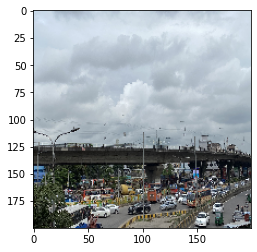

In [4]:
clean_data=clean_data[:NUMBER_OF_PICTURES]
plt.imshow(clean_data[0],cmap='binary')
new_clean=[]
for i in clean_data:
    i=i/255
    new_clean.append(i)

In [5]:
for i in new_clean:
    x=i
    x[x<0.5]=0

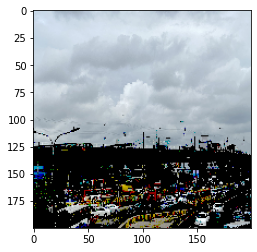

In [6]:
plt.imshow(new_clean[0],cmap='binary')

In [7]:
len(new_clean)

1818

In [8]:
arr_ind =  np.arange(NUMBER_OF_PICTURES)
mean_row=[]
for i in arr_ind:
    mean_row.append(np.mean(new_clean[i][120]))
mean_array=np.array(mean_row)

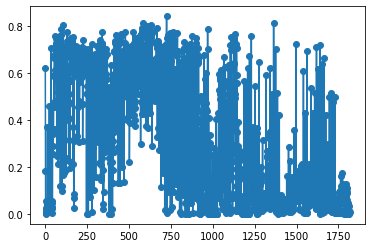

In [9]:
plt.scatter(arr_ind,mean_array)
plt.plot(arr_ind,mean_array)
plt.show()

In [10]:
for i in range(len(new_clean)):
    new_clean[i]=new_clean[i][:120]

In [11]:
df=pd.read_excel('dataset_2.0.xlsx', engine='openpyxl').head(NUMBER_OF_PICTURES)

In [12]:
y=df['PM2.5']
y=np.array(y)
print(type(y))

<class 'numpy.ndarray'>


In [13]:
new_clean[0].shape

(120, 200, 3)

In [14]:
X=new_clean
X=np.array(X)

print(type(X))


<class 'numpy.ndarray'>


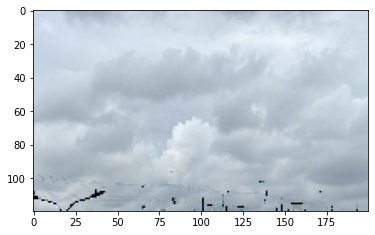

In [15]:

plt.imshow(new_clean[0],cmap='binary')

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.10, random_state = 42,shuffle=True)

In [17]:
x_train = x_train.reshape(-1,120,200, 3)

x_test = x_test.reshape(-1,120,200, 3)

In [18]:

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1636, 120, 200, 3)
(182, 120, 200, 3)
(1636,)
(182,)


In [19]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, UpSampling2D, AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [20]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input


inception = InceptionV3(input_shape=[120,200]+ [3], weights='imagenet', include_top=False)
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False
    
x = Flatten()(inception.output)
prediction = Dense(1, activation='linear')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 59, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 59, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 59, 99, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
optimum=Adam(lr=0.000001)
# model.compile(optimizer=RMSprop(lr=0.00001), loss='mean_squared_error',metrics=['mean_squared_error'])
model.compile(optimizer=optimum, loss='mean_absolute_error',metrics=['mean_squared_error',tf.keras.metrics.RootMeanSquaredError()])

C:\Users\joyan\AppData\Roaming\Python\Python36\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
import time
start = time.process_time()
hist = model.fit(x_train, y_train, 
           batch_size=8, epochs=350, validation_split=0.1 )
print(time.process_time() - start)

Epoch 1/350
184/184 [==============================] - 24s 50ms/step - loss: 145.5014 - mean_squared_error: 24437.0645 - root_mean_squared_error: 156.3236 - val_loss: 154.4170 - val_mean_squared_error: 27481.9355 - val_root_mean_squared_error: 165.7768
Epoch 2/350
184/184 [==============================] - 7s 38ms/step - loss: 144.8501 - mean_squared_error: 24245.4668 - root_mean_squared_error: 155.7096 - val_loss: 153.7630 - val_mean_squared_error: 27276.2832 - val_root_mean_squared_error: 165.1553
Epoch 3/350
184/184 [==============================] - 7s 36ms/step - loss: 144.1991 - mean_squared_error: 24056.1055 - root_mean_squared_error: 155.1003 - val_loss: 153.1115 - val_mean_squared_error: 27072.5156 - val_root_mean_squared_error: 164.5373
Epoch 4/350
184/184 [==============================] - 7s 37ms/step - loss: 143.5494 - mean_squared_error: 23869.2520 - root_mean_squared_error: 154.4968 - val_loss: 152.4621 - val_mean_squared_error: 26870.4941 - val_root_mean_squared_error: 

In [24]:
predictions = model.predict([x_test])
pred=[]
for i in predictions:
    print(int(i[0]))
    pred.append(int(i[0]))
    
for i in y_test:
    print(i)

96
126
368
255
106
115
114
105
115
141
102
139
108
127
69
95
160
77
79
111
175
98
144
102
132
202
270
151
89
263
75
90
102
131
104
131
130
130
140
120
116
110
61
92
121
149
112
85
112
78
85
106
173
109
126
116
113
98
98
90
83
130
121
109
77
105
107
169
233
90
130
85
77
222
128
127
106
95
94
78
77
205
105
94
132
244
136
114
89
90
91
139
79
194
143
123
99
118
208
106
133
104
120
125
112
188
82
201
102
145
139
90
80
154
98
139
86
93
124
119
126
124
91
91
61
103
68
118
98
119
105
147
135
94
109
209
90
118
123
118
226
92
96
161
158
113
133
104
271
169
114
107
128
78
72
100
90
103
120
133
108
212
183
160
134
76
98
143
106
119
79
163
111
121
95
64
84
107
381
197
125
155
101.0
182.0
89.0
294.0
162.0
90.0
145.0
168.0
136.0
143.0
171.0
107.0
186.0
143.0
165.0
89.0
287.0
81.0
266.0
296.0
165.0
108.0
101.0
134.0
119.0
98.0
155.0
230.0
143.0
168.0
56.0
81.0
196.0
162.0
81.0
196.0
208.0
102.0
135.0
204.0
207.0
140.0
171.0
93.0
207.0
101.0
82.0
136.0
183.0
143.0
76.0
201.0
166.0
159.0
64.0
97.0
159.0

In [25]:
diff=[]
for i in range(len(pred)):
    diff.append(abs(y_test[i]-pred[i]))
print(sum(diff) / len(diff))

55.24175824175824


In [26]:
for i in diff:
    print(i)

5.0
56.0
279.0
39.0
56.0
25.0
31.0
63.0
21.0
2.0
69.0
32.0
78.0
16.0
96.0
6.0
127.0
4.0
187.0
185.0
10.0
10.0
43.0
32.0
13.0
104.0
115.0
79.0
54.0
95.0
19.0
9.0
94.0
31.0
23.0
65.0
78.0
28.0
5.0
84.0
91.0
30.0
110.0
1.0
86.0
48.0
30.0
51.0
71.0
65.0
9.0
95.0
7.0
50.0
62.0
19.0
46.0
30.0
46.0
188.0
2.0
13.0
1.0
54.0
78.0
38.0
14.0
8.0
17.0
53.0
56.0
93.0
101.0
52.0
168.0
7.0
19.0
62.0
7.0
123.0
88.0
48.0
38.0
21.0
42.0
31.0
12.0
87.0
112.0
81.0
24.0
11.0
3.0
41.0
48.0
128.0
23.0
53.0
80.0
35.0
3.0
60.0
54.0
31.0
24.0
80.0
25.0
37.0
68.0
87.0
59.0
72.0
121.0
29.0
31.0
17.0
76.0
109.0
56.0
56.0
25.0
65.0
71.0
15.0
51.0
61.0
228.0
78.0
22.0
52.0
173.0
37.0
35.0
20.0
43.0
2.0
72.0
54.0
20.0
65.0
18.0
66.0
60.0
71.0
0.0
60.0
31.0
69.0
103.0
1.0
44.0
42.0
33.0
218.0
82.0
8.0
53.0
33.0
59.0
7.0
28.0
44.0
17.0
4.0
58.0
85.0
38.0
8.0
2.0
88.0
129.0
35.0
33.0
57.0
22.0
106.0
100.0
71.0
218.0
24.0
58.0
12.0


In [27]:
eva = model.evaluate(x_test, y_test)
print(eva)

6/6 [==============================] - 0s 40ms/step - loss: 55.1578 - mean_squared_error: 5243.7339 - root_mean_squared_error: 72.4136
[55.15781021118164, 5243.73388671875, 72.41362762451172]


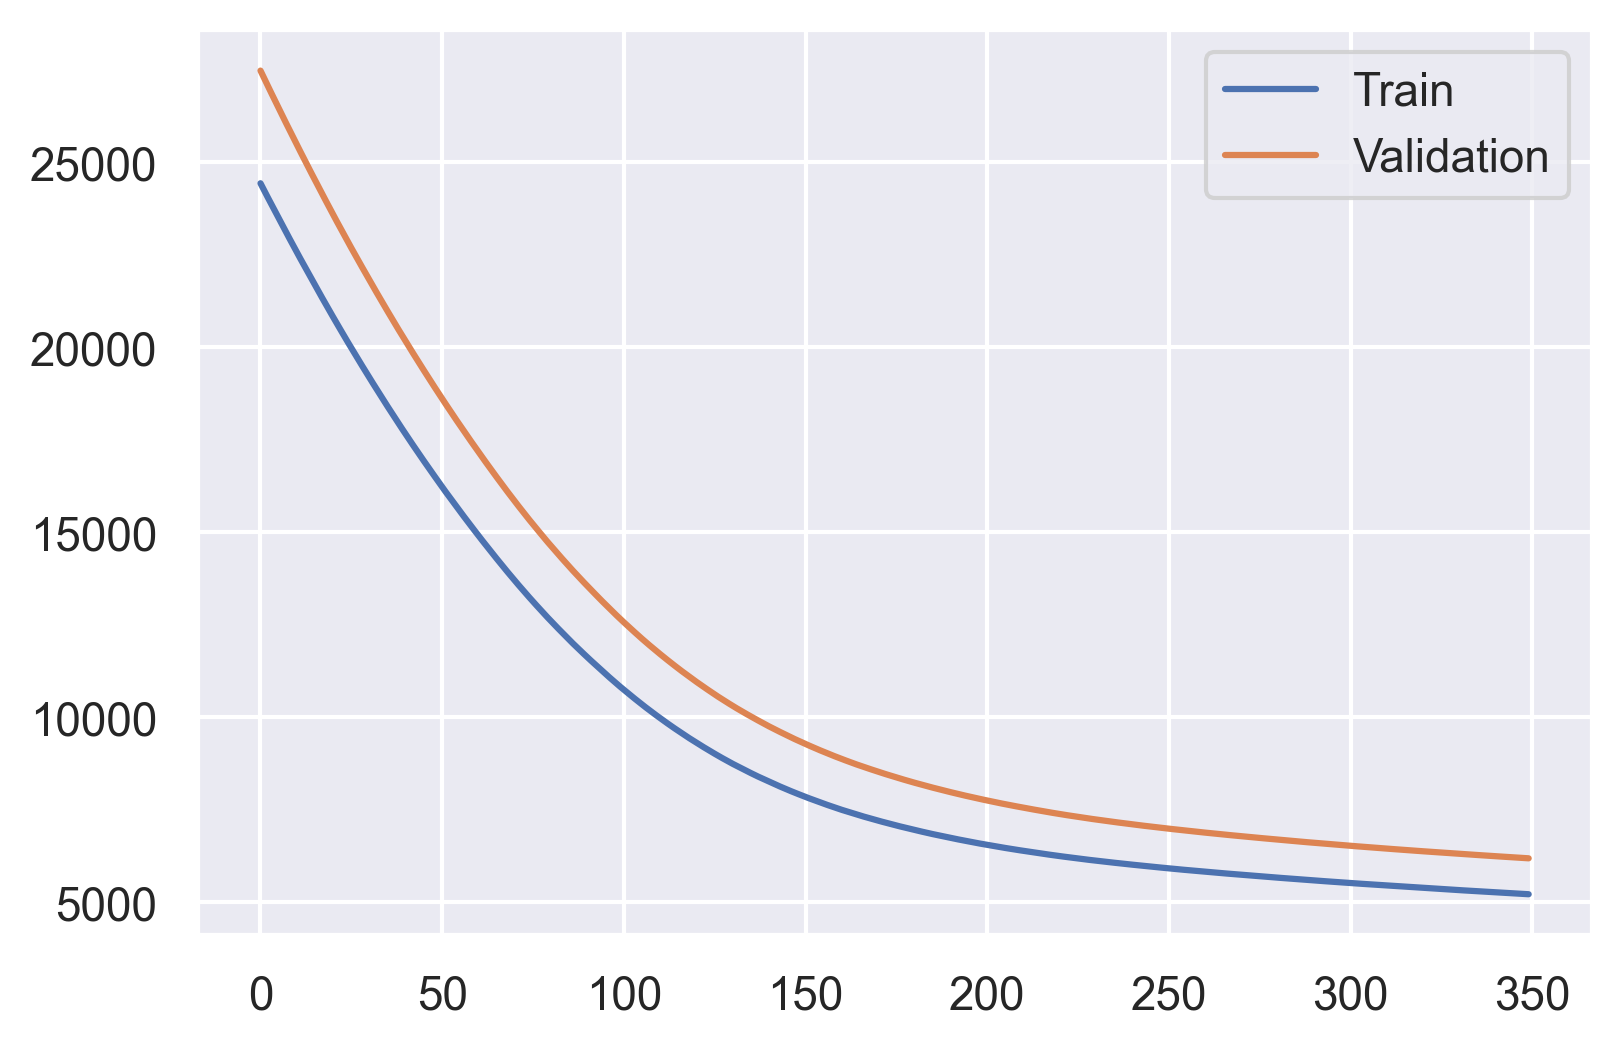

<Figure size 432x288 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# plot the loss
plt.plot(hist.history['mean_squared_error'], label='Train')
plt.plot(hist.history['val_mean_squared_error'], label='Validation')
# plt.plot(mod.history['accuracy'], label='acc_train')
# plt.plot(mod.history['val_accuracy'], label='acc_val')
plt.legend()
#plt.title('Train Loss and Validation Loss in Proposed Neural Network')
plt.gcf().set_dpi(300)
plt.show()
plt.savefig('LossVal_loss_nonaugmented')


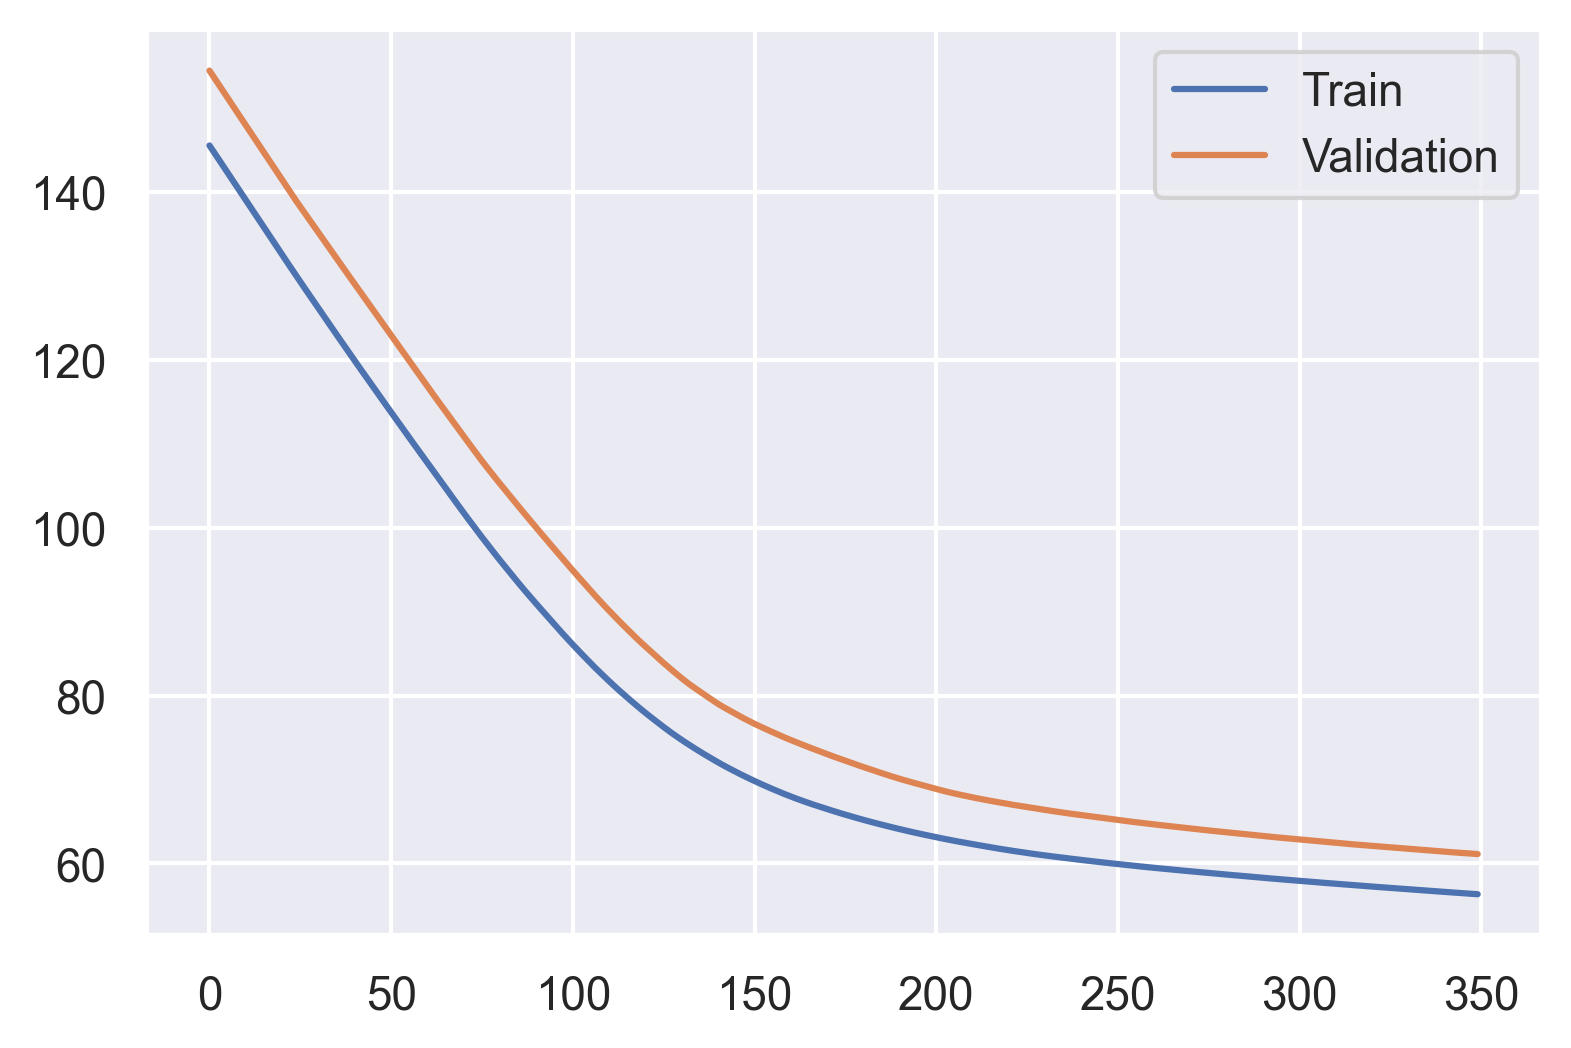

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# plot the loss
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
# plt.plot(mod.history['accuracy'], label='acc_train')
# plt.plot(mod.history['val_accuracy'], label='acc_val')
plt.legend()
#plt.title('Train Loss and Validation Loss in Proposed Neural Network')
plt.gcf().set_dpi(300)
plt.show()
plt.savefig('LossVal_loss_nonaugmented')


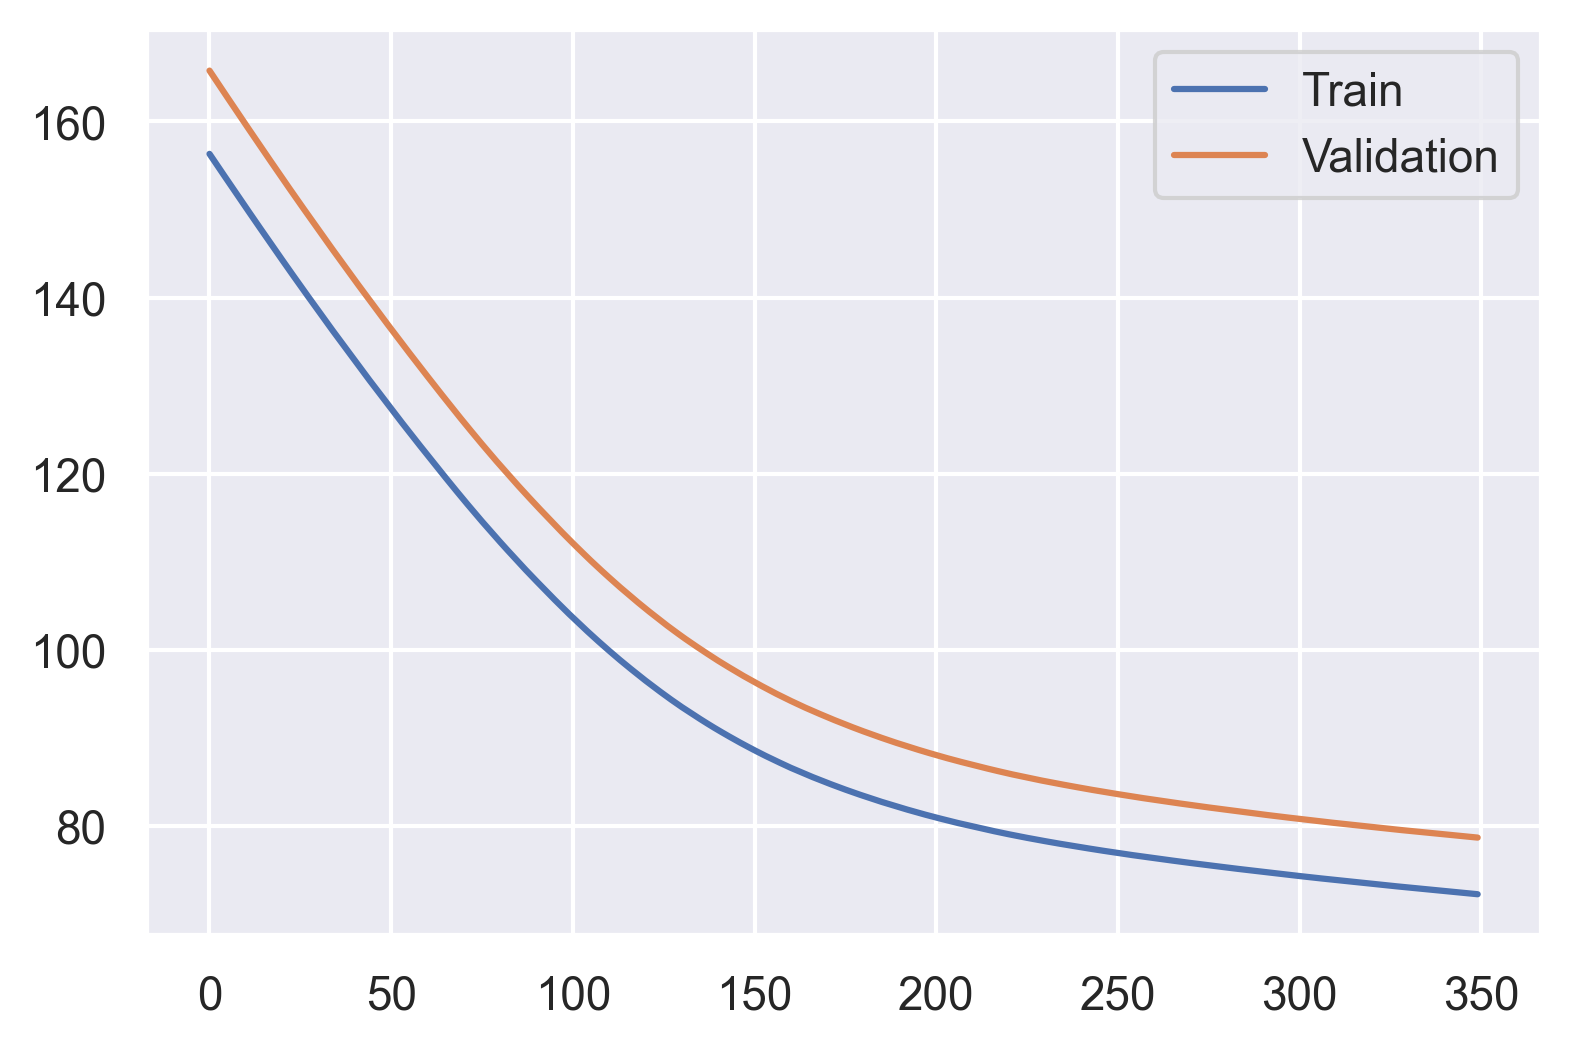

<Figure size 432x288 with 0 Axes>

In [30]:
# plot the loss
plt.plot(hist.history['root_mean_squared_error'], label='Train')
plt.plot(hist.history['val_root_mean_squared_error'], label='Validation')
# plt.plot(mod.history['accuracy'], label='acc_train')
# plt.plot(mod.history['val_accuracy'], label='acc_val')
plt.legend()
#plt.title('Train Loss and Validation Loss in Proposed Neural Network')
plt.gcf().set_dpi(300)
plt.show()
plt.savefig('LossVal_loss_nonaugmented')


In [31]:
print(len(x_test))

182


In [32]:
check_20 = 0 #check how many differences are less or equal 20
check_10 = 0 #check how many differences are less 10
check_20_50 = 0 #check how many differences are 20 to 50
check_50_more = 0 #check how many differences are more than 50
check_0 = 0
total=0
for i in diff:
    if i <= 20:
        if i == 0:
            check_0 = check_0 + 1
            total+=1
        elif i < 10:
            check_10 = check_10 + 1
            total+=1
        check_20 = check_20 + 1
    elif (20 < i or i <=50):
        check_20_50 = check_20_50 + 1
        total+=1
    elif i > 50:
        check_50_more = check_50_more + 1
        total+=1
    else:
        print("Too far")

print(check_0)
print(check_10)
print(check_20)
print(check_20_50)
print(check_50_more)
print('Near:',total)

        


1
23
43
139
0
Near: 163


In [33]:
check_20 = 0 #check how many differences are less or equal 20
check_30 = 0 #check how many differences are less or equal 30
check_40 = 0 #check how many differences are less or equal 40
check_50 = 0 #check how many differences are less or equal 60
check_10 = 0 #check how many differences are less 10
check_50_more = 0 #check how many differences are more than 50
check_0 = 0
total=0
for i in diff:
    if i == 0:
        check_0 = check_0 + 1
        total+=1
    elif i <= 10:
        check_10 = check_10 + 1
        total+=1
    elif i <= 20:
        total+=1
        check_20 = check_20 + 1
    elif i <= 30:
        total+=1
        check_30 = check_30 + 1
    elif i <= 40:
        total+=1
        check_40 = check_40 + 1
    elif i <= 50:
        total+=1
        check_50 = check_50 + 1
    elif i > 50:
        check_50_more = check_50_more + 1
        print("Too far")

print(check_0)
print(check_10)
print(check_20)
print(check_20_50)
print(check_50_more)
print('Near:',total)

        


Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
Too far
1
25
17
139
88
Near: 94


In [34]:
near_percentage = (total/len(x_test) )* 100

In [35]:
print(near_percentage)

51.64835164835166


In [36]:
len(x_test)

182

In [37]:
predic=[]
obser=[]
for i in range(len(pred)):
    predic.append(pred[i])
    obser.append(y_test[i])

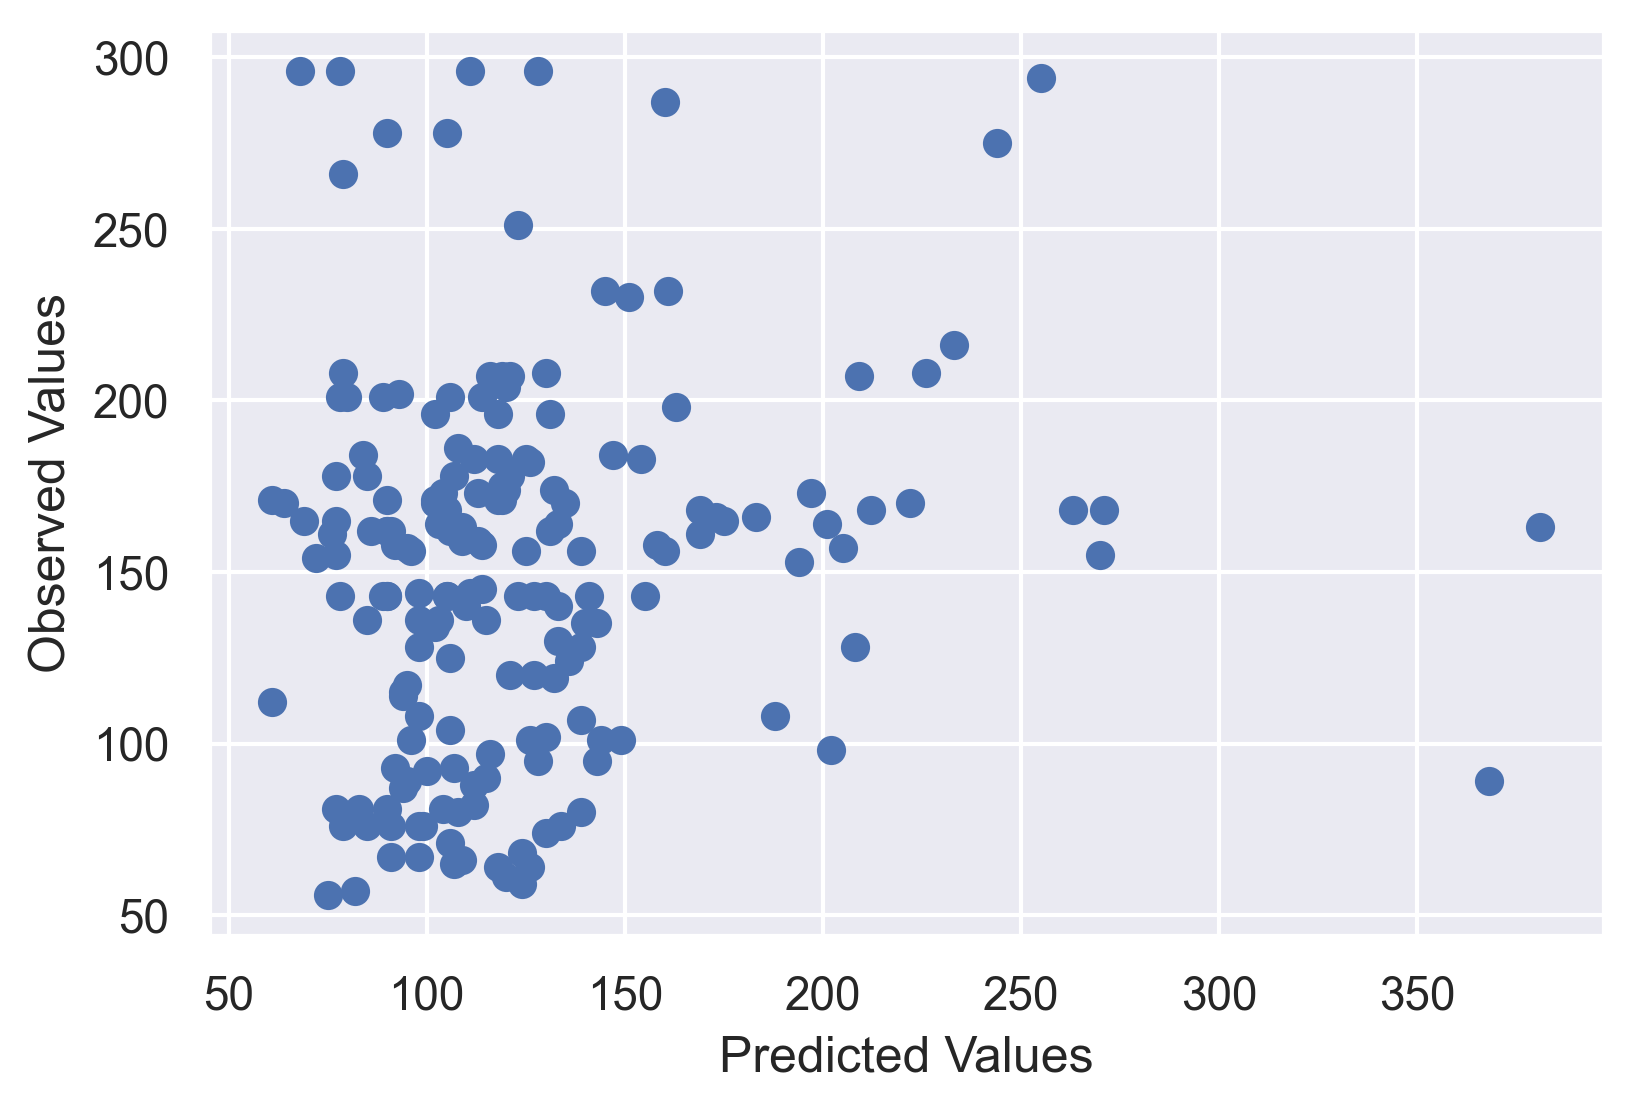

In [38]:
xpoints = np.array(predic)
ypoints = np.array(obser)

plt.scatter(xpoints, ypoints)
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.gcf().set_dpi(300)
plt.show()


In [39]:
my_rho = np.corrcoef(predic, obser)

print(my_rho)

[[1.         0.12963794]
 [0.12963794 1.        ]]


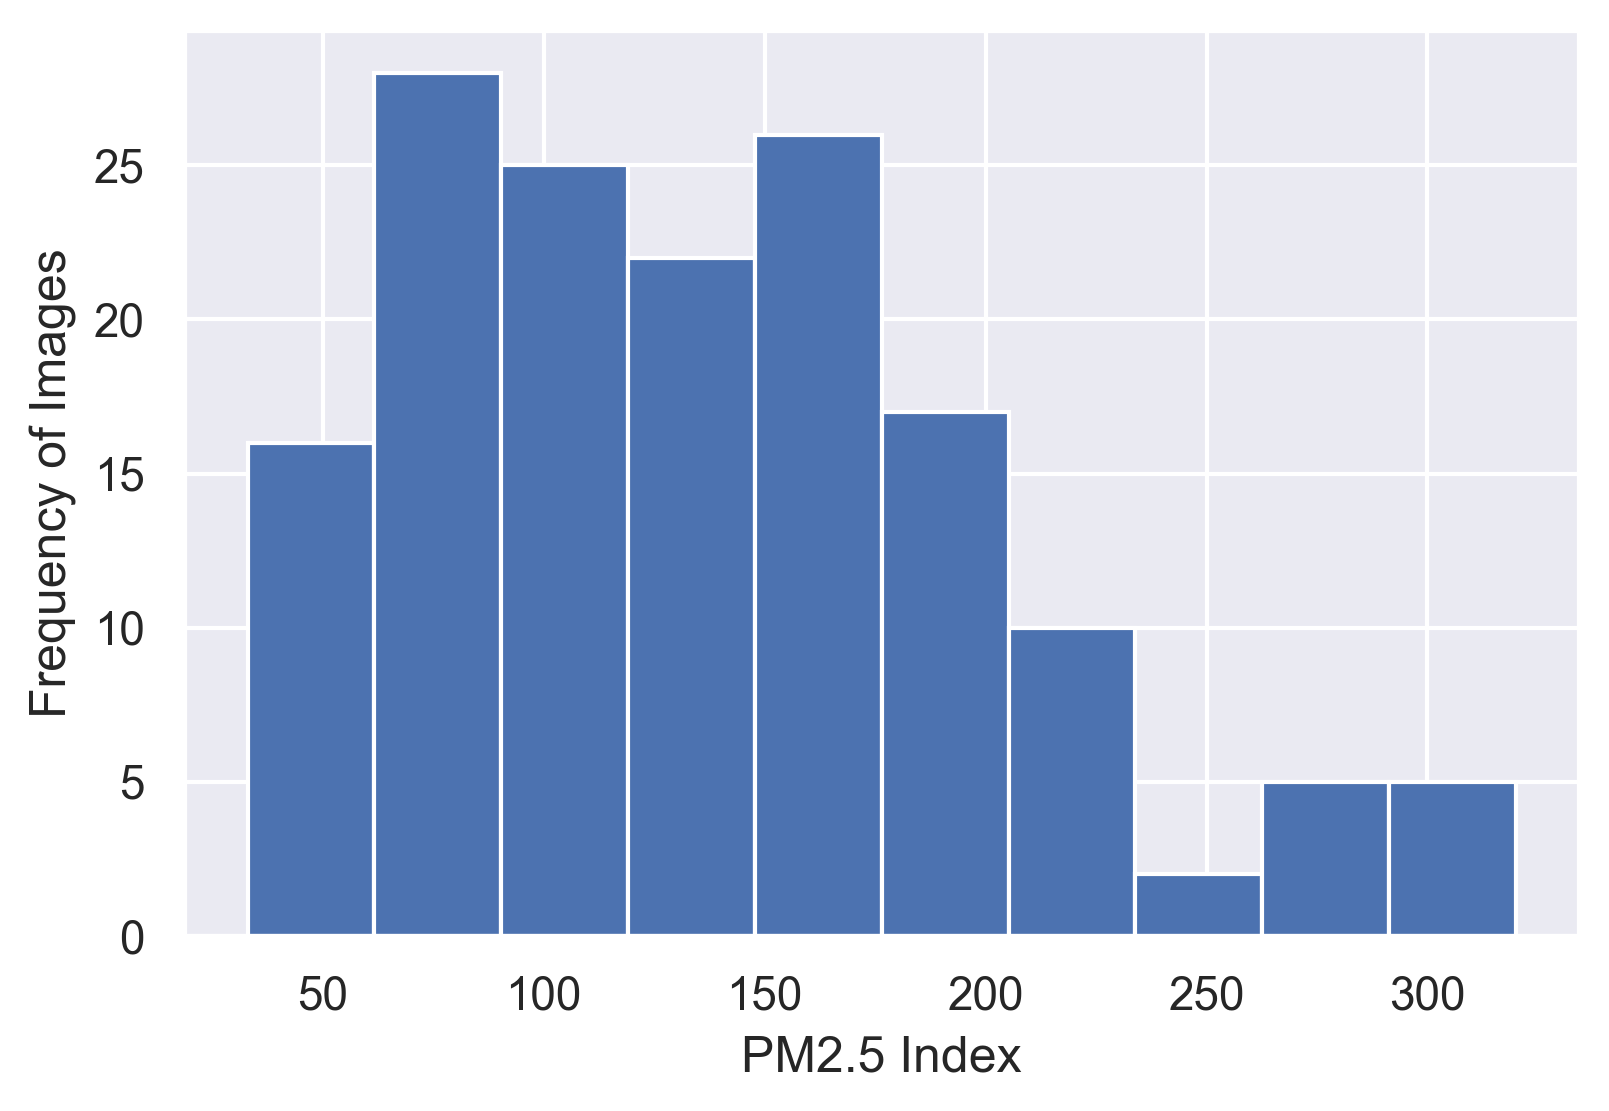

In [40]:
y = df['PM2.5']
y = np.array(y)

unique, counts = np.unique(y, return_counts=True)


xpoints = np.array(unique)
ypoints = np.array(counts)

plt.hist(xpoints)
plt.xlabel('PM2.5 Index')
plt.ylabel('Frequency of Images')
plt.gcf().set_dpi(300)
plt.show()

In [41]:
losas= tf.keras.metrics.mean_absolute_error(obser, predic)

In [42]:
losas

<tf.Tensor: shape=(), dtype=int32, numpy=55>

In [43]:

from sklearn.metrics import r2_score

r2 = r2_score(obser, predic)

In [44]:
print(r2)

-0.8066606904819056


## ResNet50

In [45]:
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input

In [46]:
resnet = ResNet50(input_shape=[120,200]+ [3], weights='imagenet', include_top=False)

In [47]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [48]:
x = Flatten()(resnet.output)

In [49]:
x = Flatten()(resnet.output)
prediction = Dense(1, activation='linear')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [50]:
# view the structure of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 126, 206, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 60, 100, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 60, 100, 64)  256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [51]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
optimum=Adam(lr=0.000001)
# model.compile(optimizer=RMSprop(lr=0.00001), loss='mean_squared_error',metrics=['mean_squared_error'])
model.compile(optimizer=optimum, loss='mean_absolute_error',metrics=['mean_squared_error',tf.keras.metrics.RootMeanSquaredError()])

C:\Users\joyan\AppData\Roaming\Python\Python36\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [52]:
import time
start = time.process_time()
hist = model.fit(x_train, y_train, 
           batch_size=8, epochs=350, validation_split=0.1 )
print(time.process_time() - start)

Epoch 1/350
184/184 [==============================] - 13s 35ms/step - loss: 146.0830 - mean_squared_error: 24618.9648 - root_mean_squared_error: 156.9043 - val_loss: 154.7985 - val_mean_squared_error: 27616.2559 - val_root_mean_squared_error: 166.1814
Epoch 2/350
184/184 [==============================] - 5s 27ms/step - loss: 144.9698 - mean_squared_error: 24295.2031 - root_mean_squared_error: 155.8692 - val_loss: 153.6879 - val_mean_squared_error: 27274.1777 - val_root_mean_squared_error: 165.1490
Epoch 3/350
184/184 [==============================] - 5s 28ms/step - loss: 143.8567 - mean_squared_error: 23974.5156 - root_mean_squared_error: 154.8371 - val_loss: 152.5769 - val_mean_squared_error: 26934.5000 - val_root_mean_squared_error: 164.1173
Epoch 4/350
184/184 [==============================] - 5s 28ms/step - loss: 142.7435 - mean_squared_error: 23655.2637 - root_mean_squared_error: 153.8027 - val_loss: 151.4664 - val_mean_squared_error: 26597.3906 - val_root_mean_squared_error: 

In [53]:
predictions = model.predict([x_test])
pred=[]
for i in predictions:
    print(int(i[0]))
    pred.append(int(i[0]))
    
for i in y_test:
    print(i)
    
diff=[]
for i in range(len(pred)):
    diff.append(abs(y_test[i]-pred[i]))
print(sum(diff) / len(diff))


for i in diff:
    print(i)

147
153
157
151
158
146
158
150
148
152
157
159
154
152
158
156
158
155
157
156
160
158
153
158
151
149
155
162
155
154
158
155
157
152
150
156
153
149
150
159
154
151
157
152
146
153
151
155
160
158
156
156
155
150
148
151
149
148
158
159
158
149
151
149
158
158
147
159
156
156
149
158
156
159
141
152
150
148
158
157
159
151
154
156
158
146
149
156
157
158
148
158
150
152
152
157
154
158
157
151
151
157
158
148
153
155
149
155
158
160
152
158
158
155
151
158
157
158
158
160
150
158
155
158
157
158
155
158
148
159
158
161
150
155
149
154
151
148
151
152
157
149
150
153
158
158
158
151
141
167
158
153
148
152
154
158
153
158
152
150
149
154
155
156
143
157
148
149
154
151
156
158
158
158
152
158
143
158
158
155
150
151
101.0
182.0
89.0
294.0
162.0
90.0
145.0
168.0
136.0
143.0
171.0
107.0
186.0
143.0
165.0
89.0
287.0
81.0
266.0
296.0
165.0
108.0
101.0
134.0
119.0
98.0
155.0
230.0
143.0
168.0
56.0
81.0
196.0
162.0
81.0
196.0
208.0
102.0
135.0
204.0
207.0
140.0
171.0
93.0
207.0
101.0
82.0


In [54]:
eva = model.evaluate(x_test, y_test)
print(eva)

6/6 [==============================] - 0s 44ms/step - loss: 40.2249 - mean_squared_error: 2840.5669 - root_mean_squared_error: 53.2970
[40.224945068359375, 2840.56689453125, 53.29697036743164]


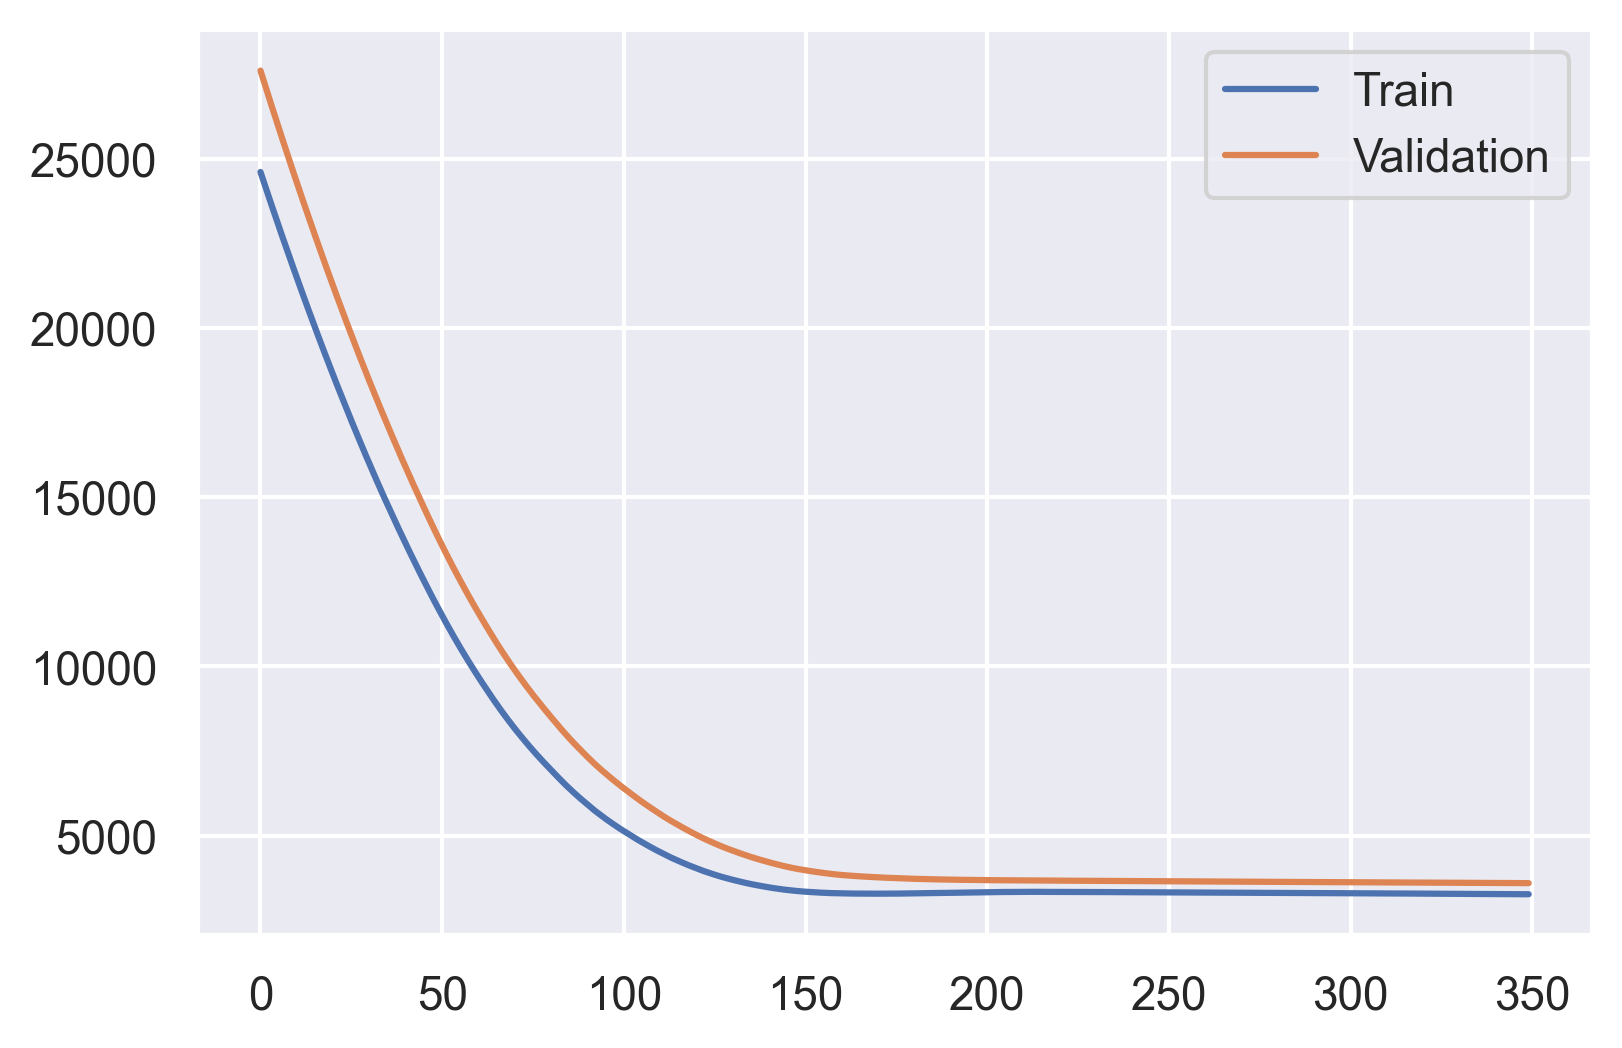

<Figure size 432x288 with 0 Axes>

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# plot the loss
plt.plot(hist.history['mean_squared_error'], label='Train')
plt.plot(hist.history['val_mean_squared_error'], label='Validation')
# plt.plot(mod.history['accuracy'], label='acc_train')
# plt.plot(mod.history['val_accuracy'], label='acc_val')
plt.legend()
#plt.title('Train Loss and Validation Loss in Proposed Neural Network')
plt.gcf().set_dpi(300)
plt.show()
plt.savefig('LossVal_loss_nonaugmented')


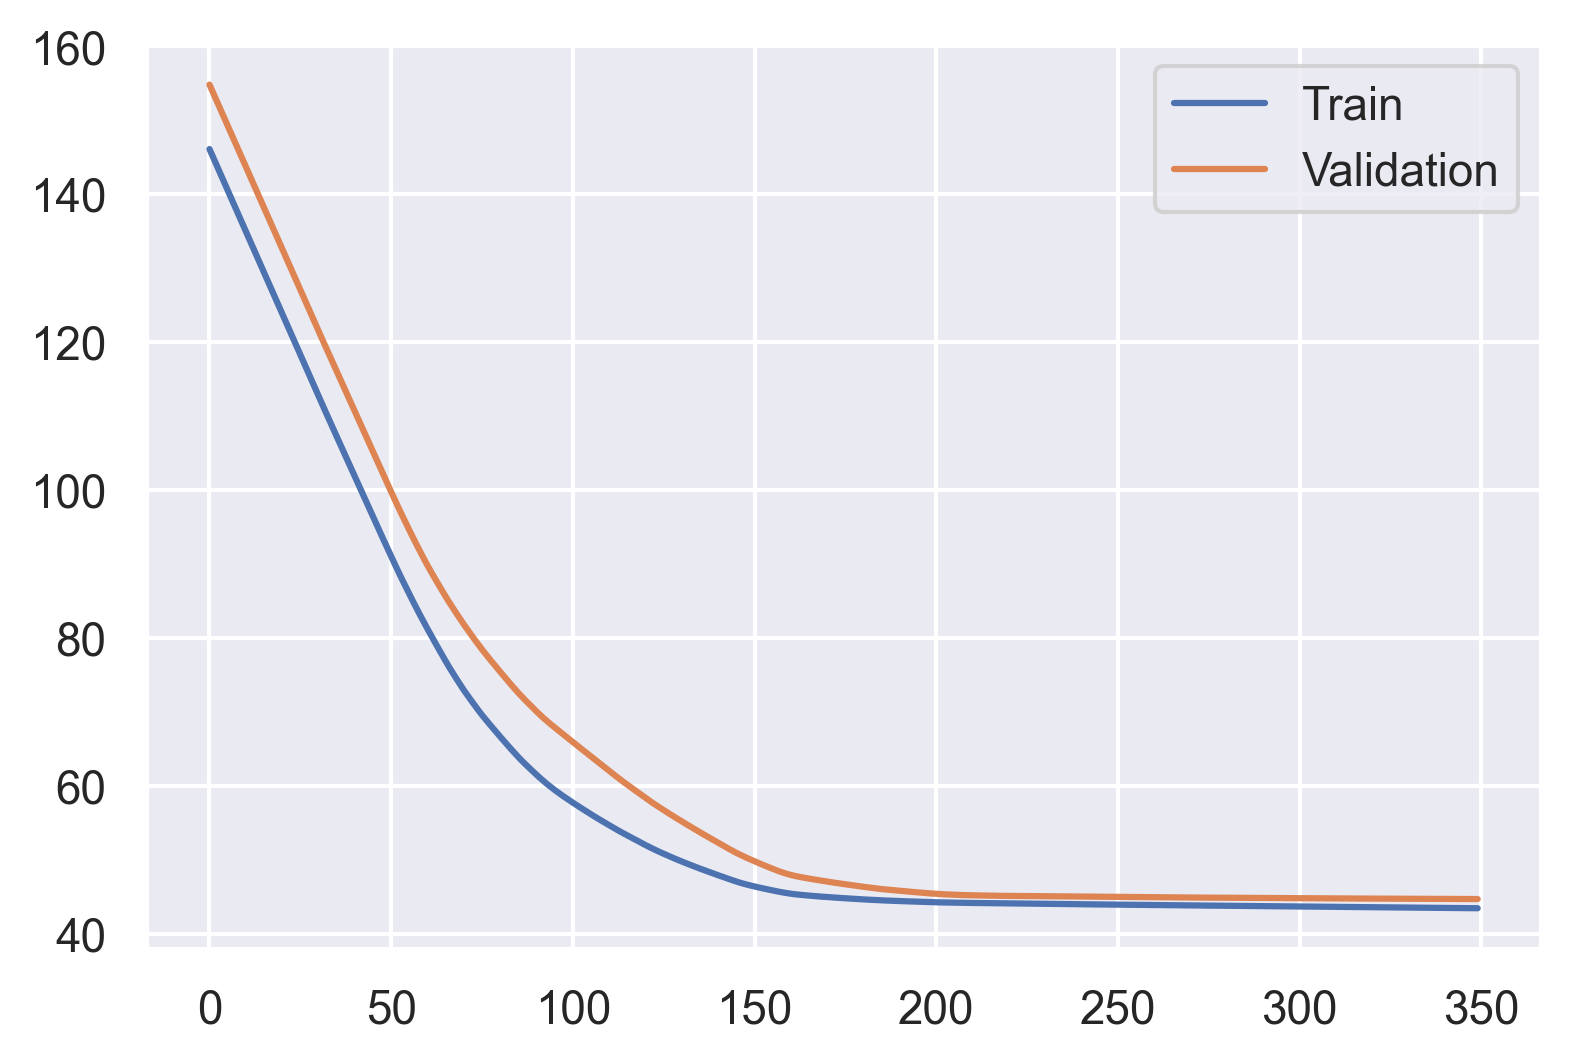

<Figure size 432x288 with 0 Axes>

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# plot the loss
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
# plt.plot(mod.history['accuracy'], label='acc_train')
# plt.plot(mod.history['val_accuracy'], label='acc_val')
plt.legend()
#plt.title('Train Loss and Validation Loss in Proposed Neural Network')
plt.gcf().set_dpi(300)
plt.show()
plt.savefig('LossVal_loss_nonaugmented')


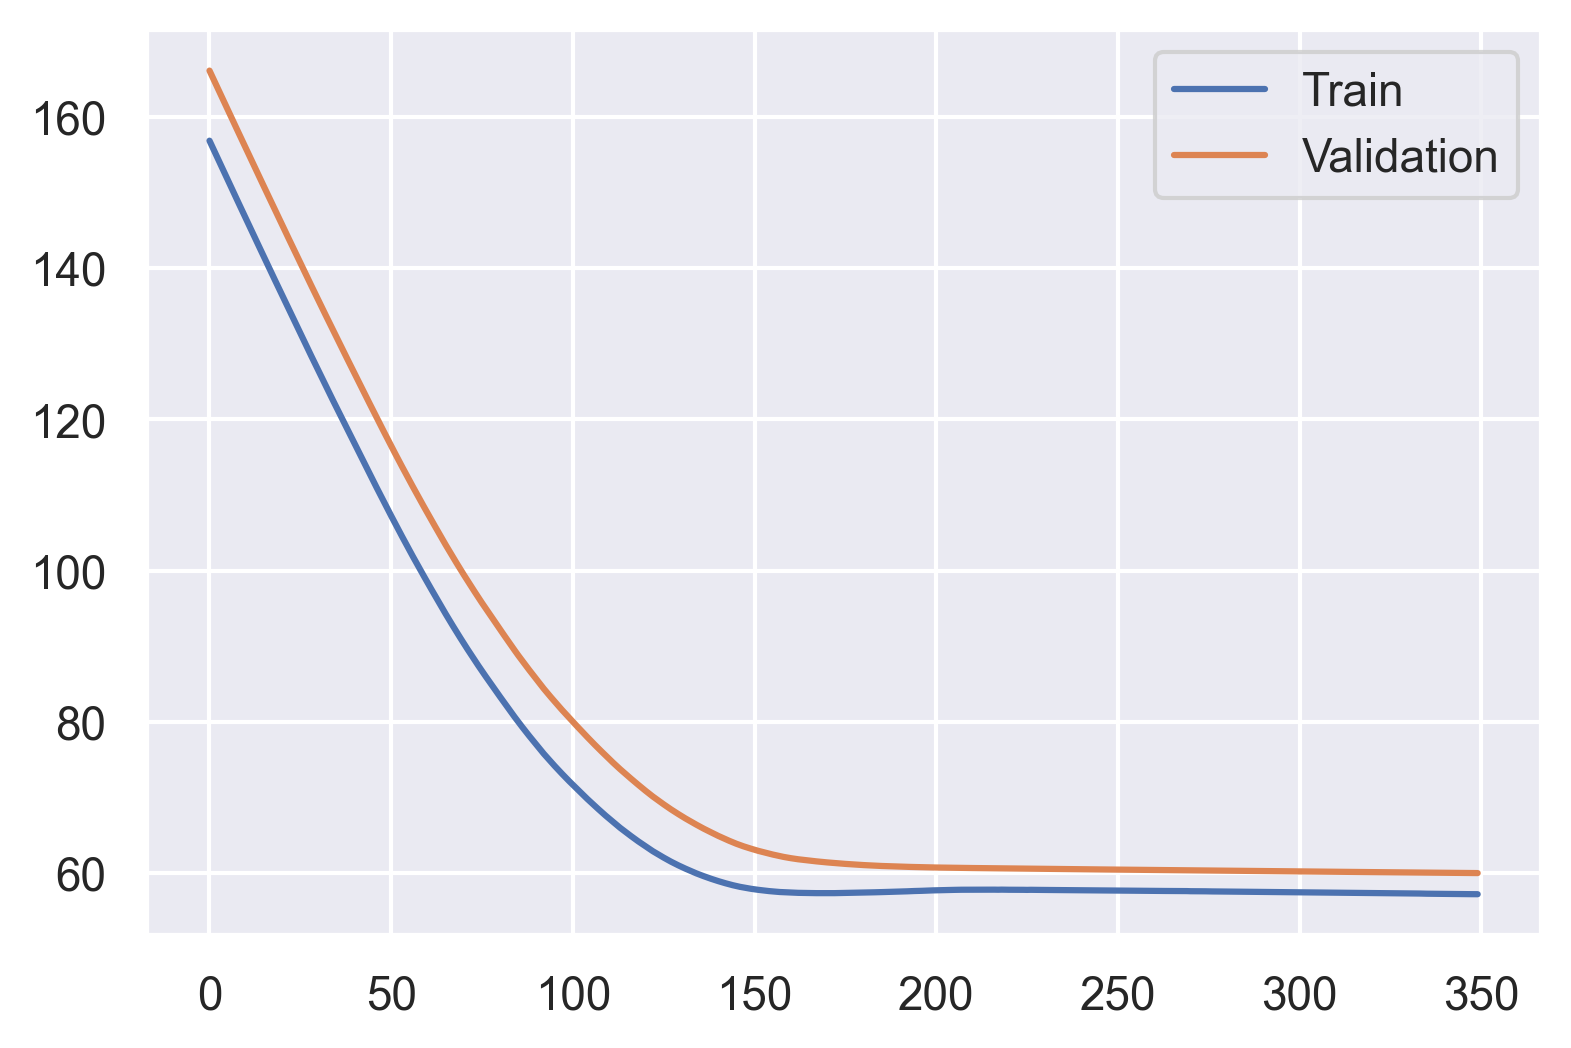

<Figure size 432x288 with 0 Axes>

In [57]:
# plot the loss
plt.plot(hist.history['root_mean_squared_error'], label='Train')
plt.plot(hist.history['val_root_mean_squared_error'], label='Validation')
# plt.plot(mod.history['accuracy'], label='acc_train')
# plt.plot(mod.history['val_accuracy'], label='acc_val')
plt.legend()
#plt.title('Train Loss and Validation Loss in Proposed Neural Network')
plt.gcf().set_dpi(300)
plt.show()
plt.savefig('LossVal_loss_nonaugmented')


In [58]:
predic=[]
obser=[]
for i in range(len(pred)):
    predic.append(pred[i])
    obser.append(y_test[i])

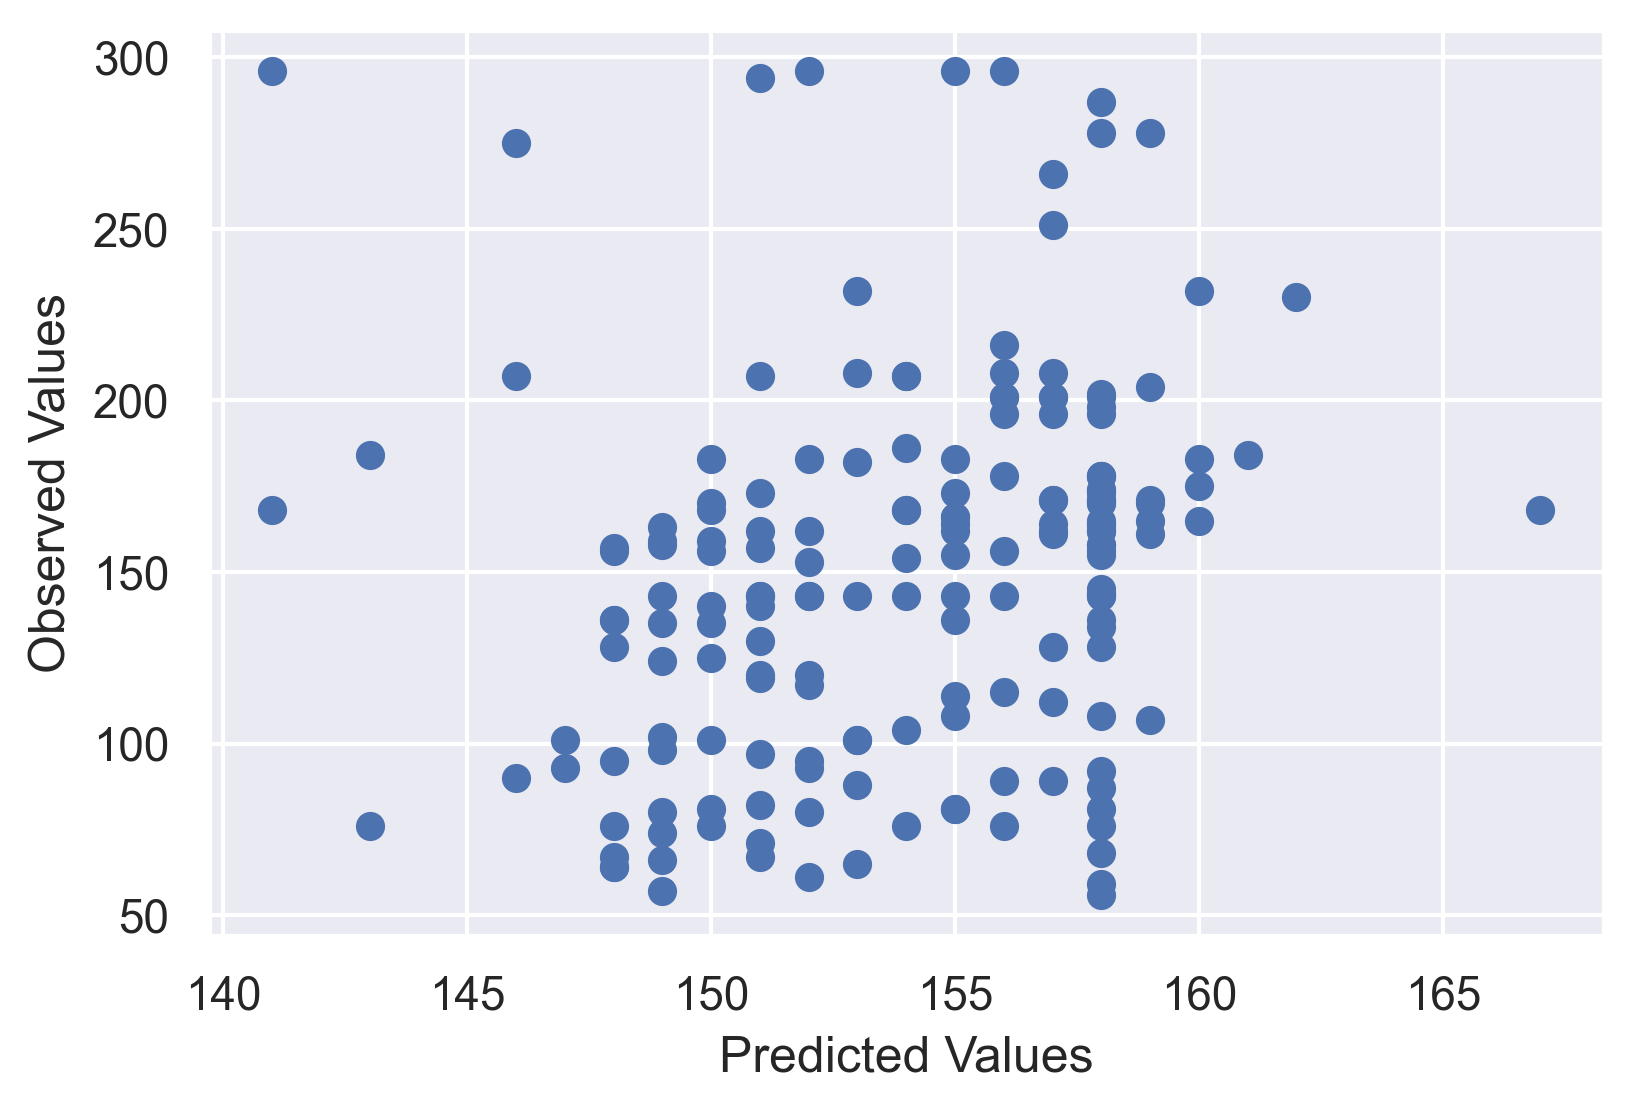

In [59]:
xpoints = np.array(predic)
ypoints = np.array(obser)

plt.scatter(xpoints, ypoints)
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.gcf().set_dpi(300)
plt.show()


In [60]:
my_rho = np.corrcoef(predic, obser)

print(my_rho)

[[1.         0.22831167]
 [0.22831167 1.        ]]


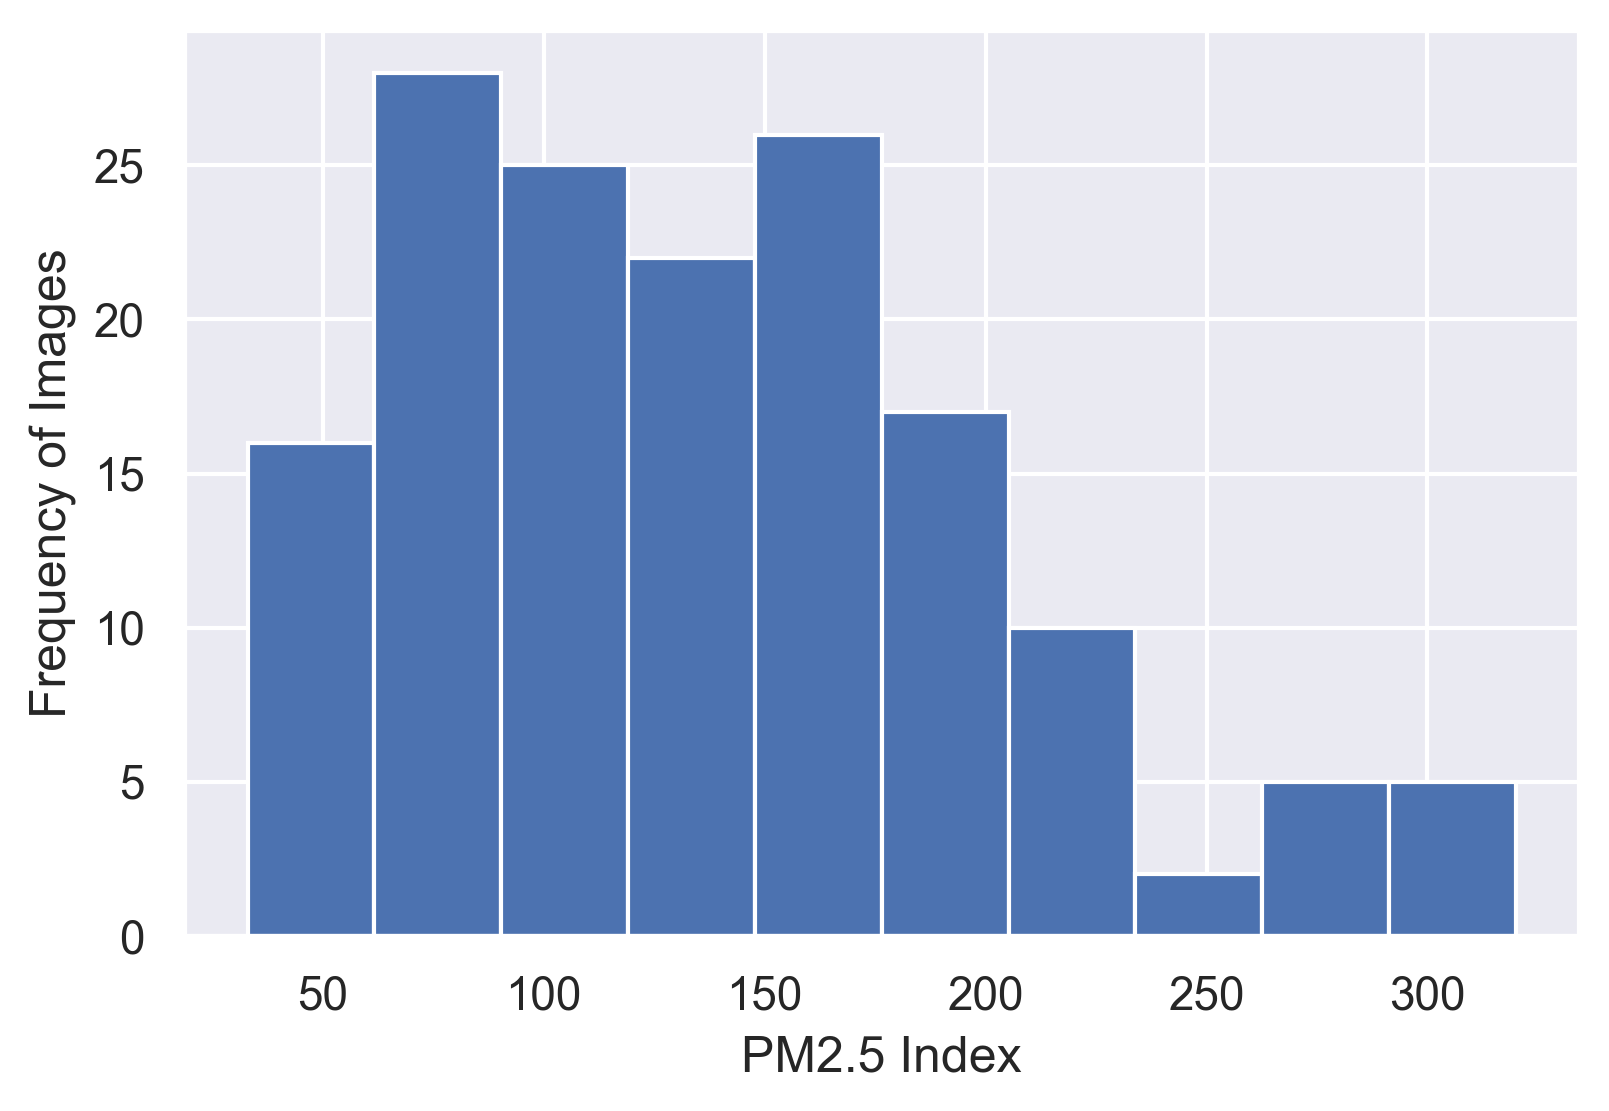

In [61]:
y = df['PM2.5']
y = np.array(y)

unique, counts = np.unique(y, return_counts=True)


xpoints = np.array(unique)
ypoints = np.array(counts)

plt.hist(xpoints)
plt.xlabel('PM2.5 Index')
plt.ylabel('Frequency of Images')
plt.gcf().set_dpi(300)
plt.show()

In [62]:
losas= tf.keras.metrics.mean_absolute_error(obser, predic)
losas

<tf.Tensor: shape=(), dtype=int32, numpy=40>

In [63]:

from sklearn.metrics import r2_score

r2 = r2_score(obser, predic)
r2

0.026226505903287567

## VGG19

In [64]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg19 = VGG19(input_shape=[120,200]+ [3], weights='imagenet', include_top=False)
# don't train existing weights
for layer in vgg19.layers:
    layer.trainable = False
    
x = Flatten()(vgg19.output)
prediction = Dense(1, activation='linear')(x)

# create a model object
model = Model(inputs=vgg19.input, outputs=prediction)
# view the structure of the model
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 100, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 100, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 100, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 50, 128)       0   

In [65]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
optimum=Adam(lr=0.000001)
# model.compile(optimizer=RMSprop(lr=0.00001), loss='mean_squared_error',metrics=['mean_squared_error'])
model.compile(optimizer=optimum, loss='mean_absolute_error',metrics=['mean_squared_error',tf.keras.metrics.RootMeanSquaredError()])

C:\Users\joyan\AppData\Roaming\Python\Python36\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [66]:
import time
start = time.process_time()
hist = model.fit(x_train, y_train, 
           batch_size=8, epochs=350, validation_split=0.1 )
print(time.process_time() - start)

Epoch 1/350
184/184 [==============================] - 12s 53ms/step - loss: 145.6548 - mean_squared_error: 24498.0059 - root_mean_squared_error: 156.5184 - val_loss: 154.8495 - val_mean_squared_error: 27636.3145 - val_root_mean_squared_error: 166.2417
Epoch 2/350
184/184 [==============================] - 6s 31ms/step - loss: 145.4275 - mean_squared_error: 24431.4121 - root_mean_squared_error: 156.3055 - val_loss: 154.6206 - val_mean_squared_error: 27565.2285 - val_root_mean_squared_error: 166.0278
Epoch 3/350
184/184 [==============================] - 6s 32ms/step - loss: 145.2003 - mean_squared_error: 24365.0996 - root_mean_squared_error: 156.0932 - val_loss: 154.3919 - val_mean_squared_error: 27494.2676 - val_root_mean_squared_error: 165.8139
Epoch 4/350
184/184 [==============================] - 6s 31ms/step - loss: 144.9730 - mean_squared_error: 24298.6797 - root_mean_squared_error: 155.8803 - val_loss: 154.1630 - val_mean_squared_error: 27423.3574 - val_root_mean_squared_error: 

In [67]:
predictions = model.predict([x_test])
pred=[]
for i in predictions:
    print(int(i[0]))
    pred.append(int(i[0]))
    
for i in y_test:
    print(i)
    
diff=[]
for i in range(len(pred)):
    diff.append(abs(y_test[i]-pred[i]))
print(sum(diff) / len(diff))


for i in diff:
    print(i)

77
76
86
81
83
75
88
76
76
75
71
83
91
75
77
73
88
76
71
78
87
74
77
71
75
76
94
78
78
94
70
76
79
81
76
78
93
77
74
80
79
76
75
76
81
76
74
73
72
71
72
73
79
74
76
76
74
78
72
73
73
77
75
76
71
85
76
86
95
76
77
75
71
85
75
76
77
77
71
76
77
89
74
75
92
93
74
85
71
69
76
97
77
81
77
85
75
91
81
76
75
71
84
79
75
82
76
78
75
81
76
77
71
85
76
81
72
73
73
75
75
73
79
79
75
73
76
86
75
78
76
91
74
74
76
85
75
75
77
74
86
76
75
80
94
77
77
79
79
77
77
90
76
78
75
70
77
75
80
75
78
86
79
78
80
76
75
75
79
78
75
79
74
77
76
71
77
72
85
86
75
76
101.0
182.0
89.0
294.0
162.0
90.0
145.0
168.0
136.0
143.0
171.0
107.0
186.0
143.0
165.0
89.0
287.0
81.0
266.0
296.0
165.0
108.0
101.0
134.0
119.0
98.0
155.0
230.0
143.0
168.0
56.0
81.0
196.0
162.0
81.0
196.0
208.0
102.0
135.0
204.0
207.0
140.0
171.0
93.0
207.0
101.0
82.0
136.0
183.0
143.0
76.0
201.0
166.0
159.0
64.0
97.0
159.0
128.0
144.0
278.0
81.0
143.0
120.0
163.0
155.0
143.0
93.0
161.0
216.0
143.0
74.0
178.0
178.0
170.0
296.0
120.0
125.0
157.0
87

In [68]:
eva = model.evaluate(x_test, y_test)
print(eva)

6/6 [==============================] - 1s 66ms/step - loss: 74.1528 - mean_squared_error: 8034.0366 - root_mean_squared_error: 89.6328
[74.15280151367188, 8034.03662109375, 89.6327896118164]


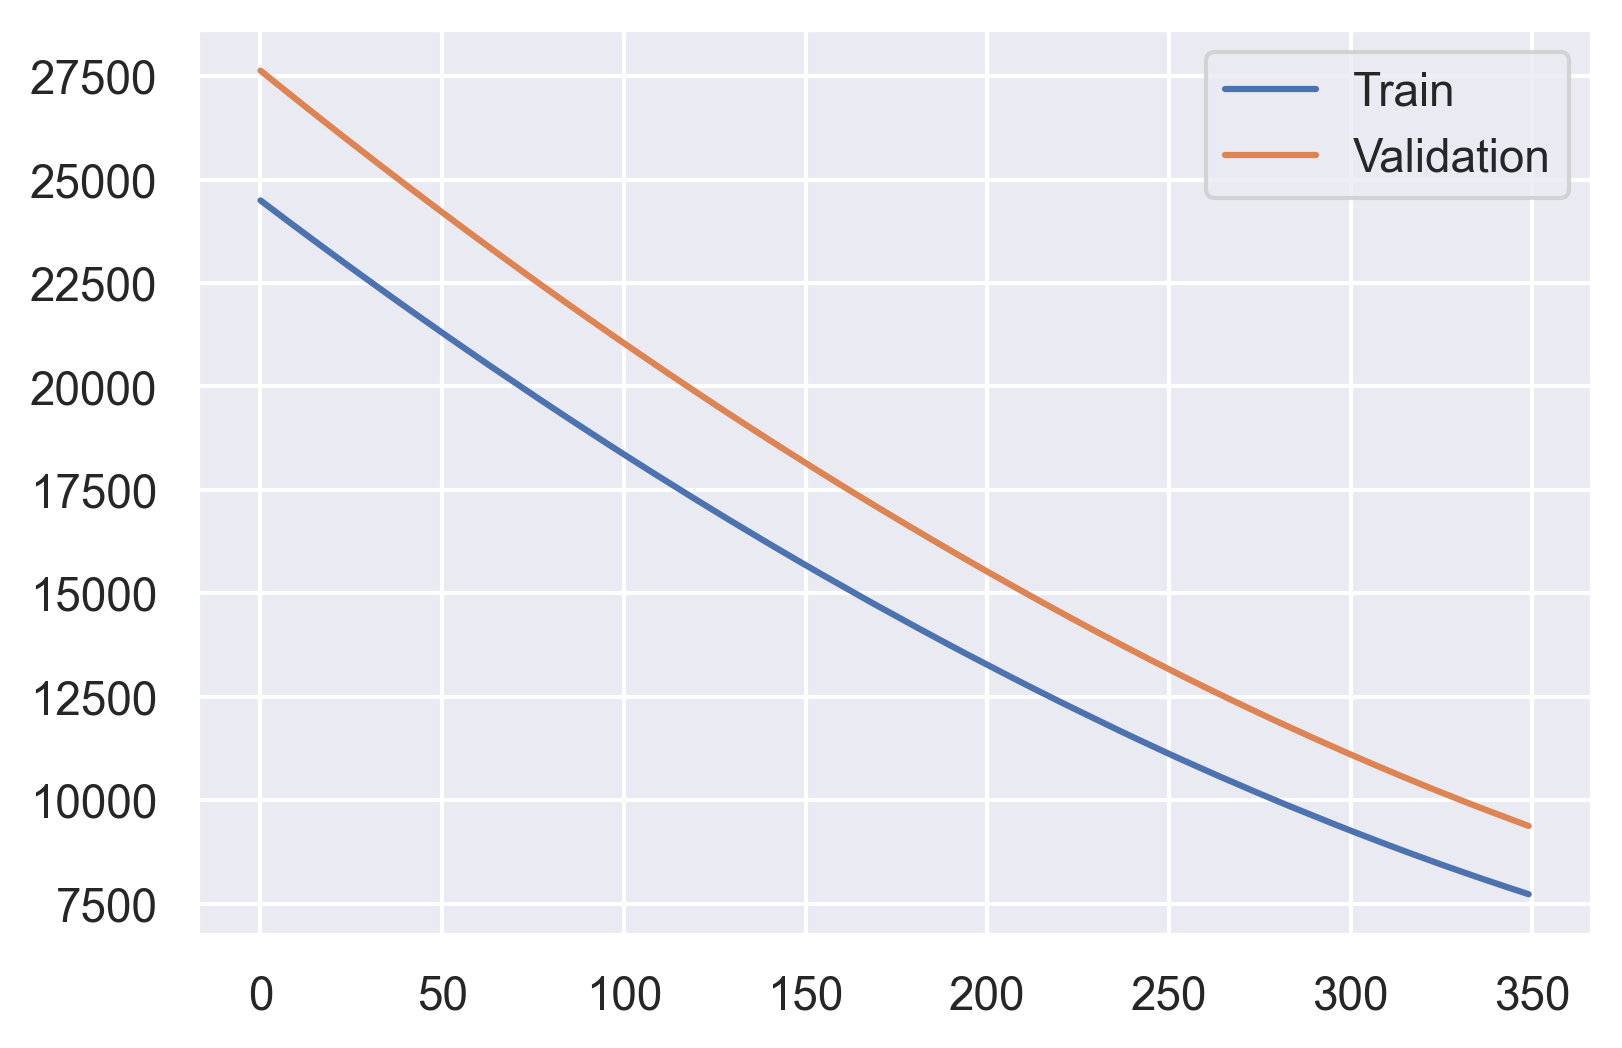

<Figure size 432x288 with 0 Axes>

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# plot the loss
plt.plot(hist.history['mean_squared_error'], label='Train')
plt.plot(hist.history['val_mean_squared_error'], label='Validation')
# plt.plot(mod.history['accuracy'], label='acc_train')
# plt.plot(mod.history['val_accuracy'], label='acc_val')
plt.legend()
#plt.title('Train Loss and Validation Loss in Proposed Neural Network')
plt.gcf().set_dpi(300)
plt.show()
plt.savefig('LossVal_loss_nonaugmented')


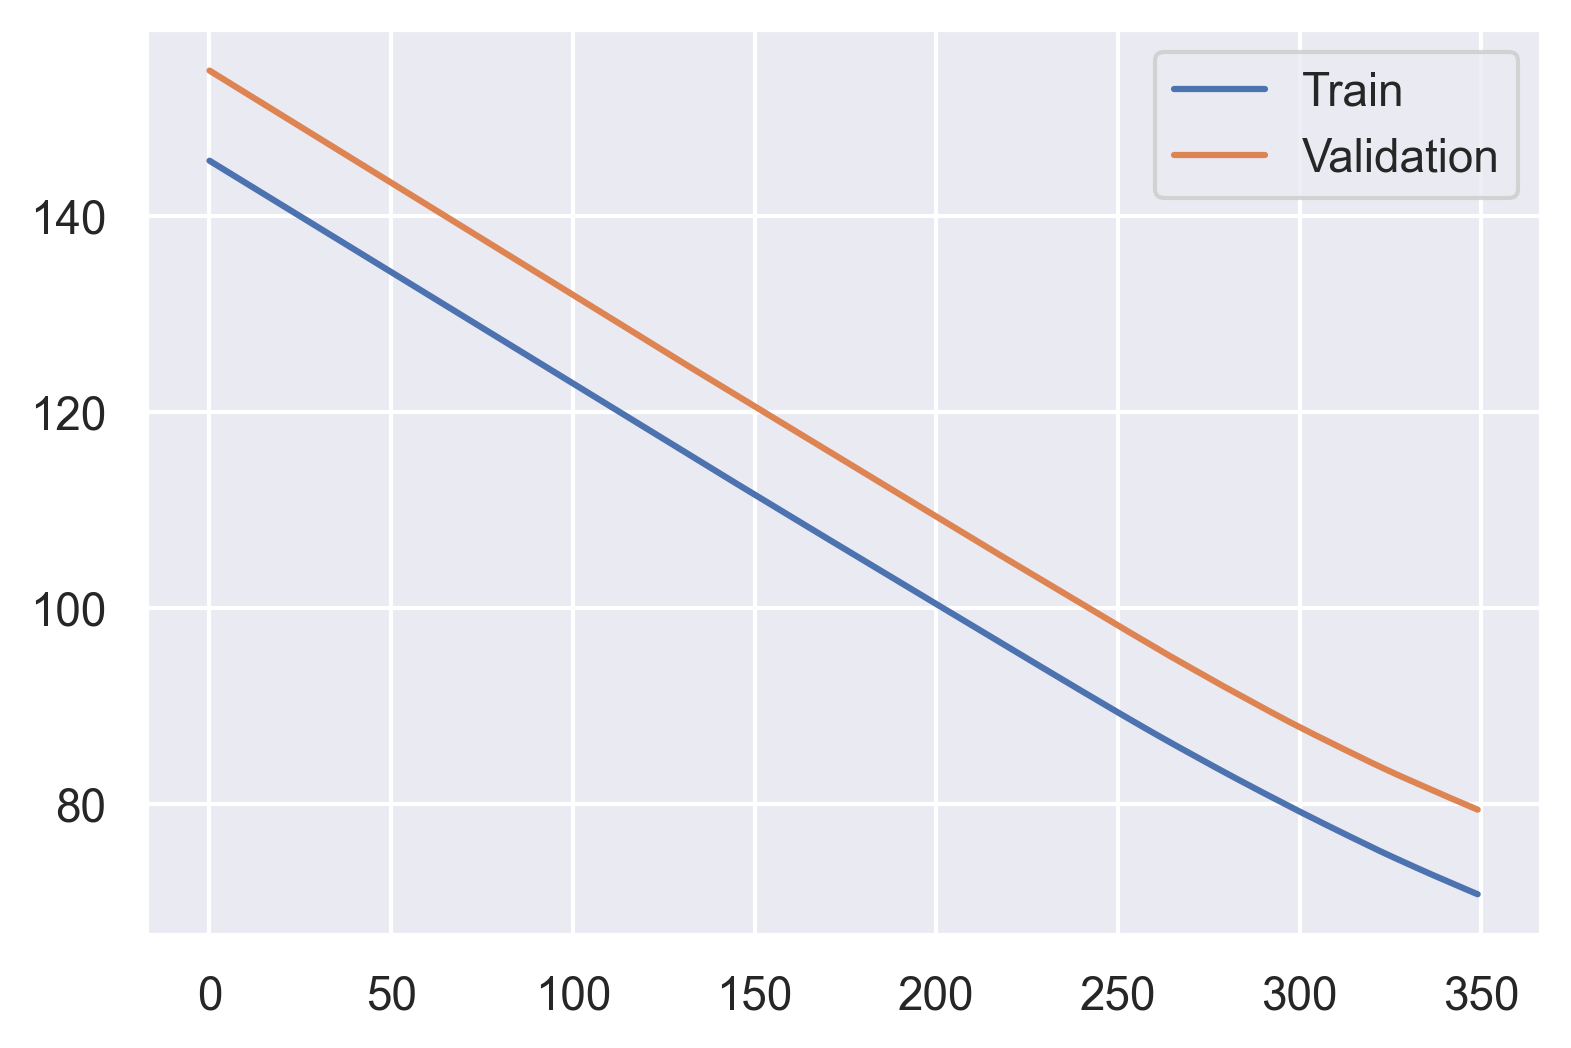

<Figure size 432x288 with 0 Axes>

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# plot the loss
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
# plt.plot(mod.history['accuracy'], label='acc_train')
# plt.plot(mod.history['val_accuracy'], label='acc_val')
plt.legend()
#plt.title('Train Loss and Validation Loss in Proposed Neural Network')
plt.gcf().set_dpi(300)
plt.show()
plt.savefig('LossVal_loss_nonaugmented')


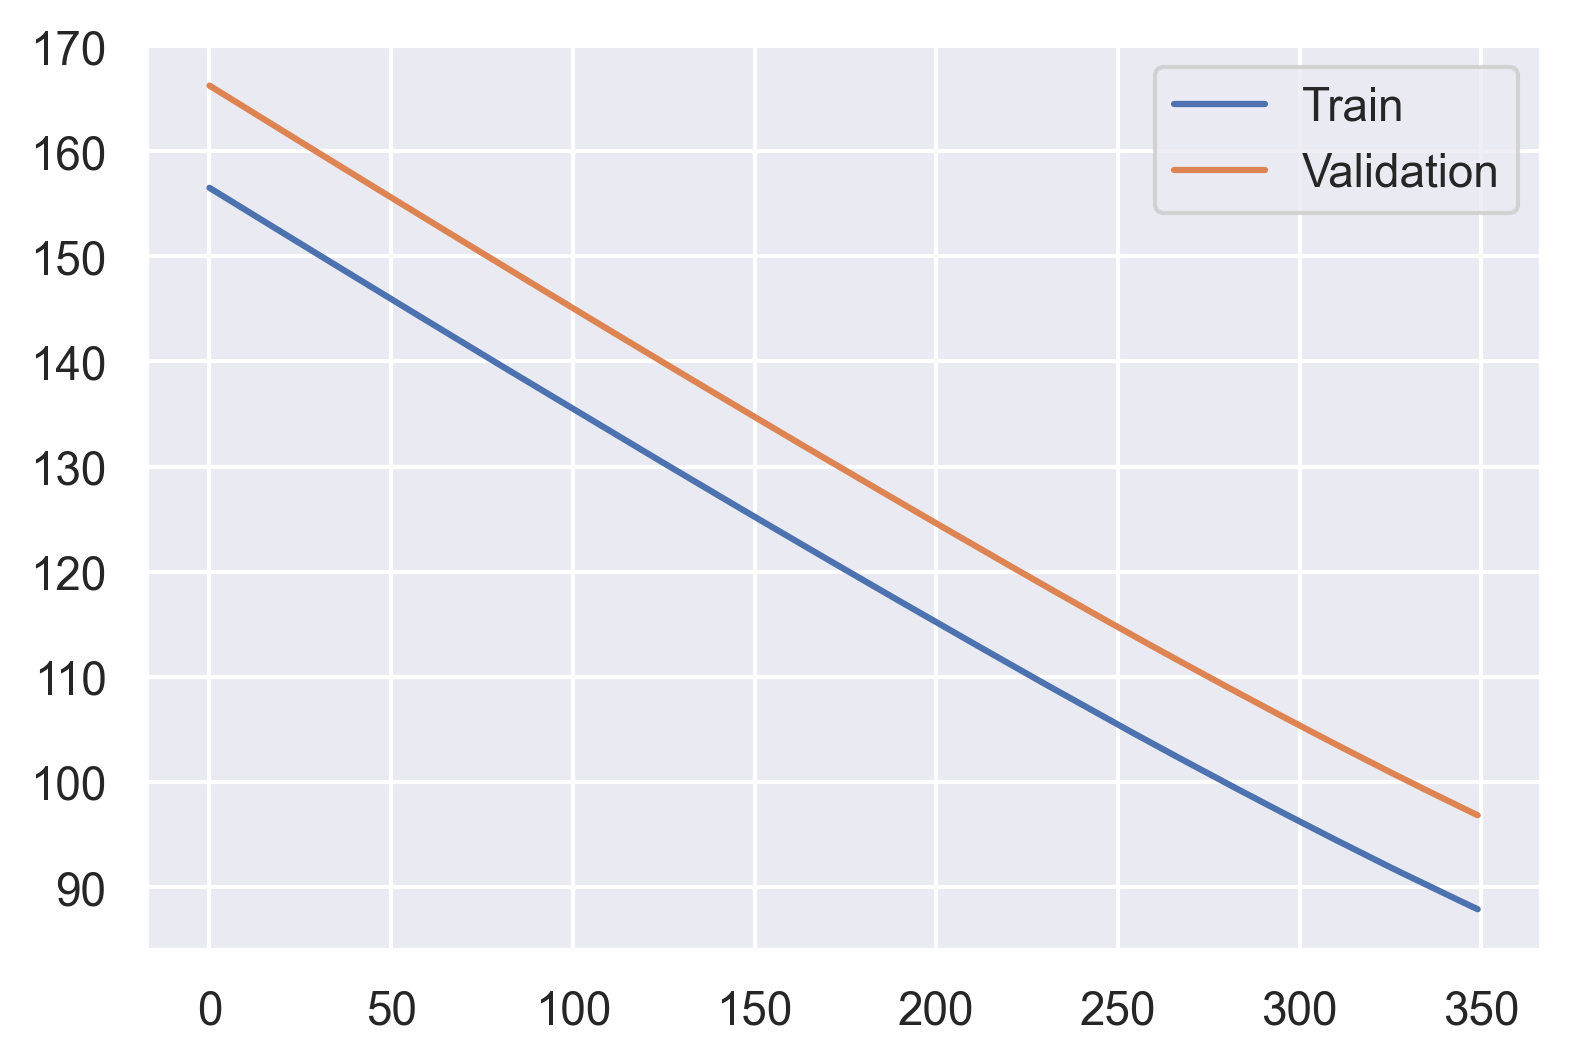

<Figure size 432x288 with 0 Axes>

In [71]:
# plot the loss
plt.plot(hist.history['root_mean_squared_error'], label='Train')
plt.plot(hist.history['val_root_mean_squared_error'], label='Validation')
# plt.plot(mod.history['accuracy'], label='acc_train')
# plt.plot(mod.history['val_accuracy'], label='acc_val')
plt.legend()
#plt.title('Train Loss and Validation Loss in Proposed Neural Network')
plt.gcf().set_dpi(300)
plt.show()
plt.savefig('LossVal_loss_nonaugmented')


In [72]:
predic=[]
obser=[]
for i in range(len(pred)):
    predic.append(pred[i])
    obser.append(y_test[i])

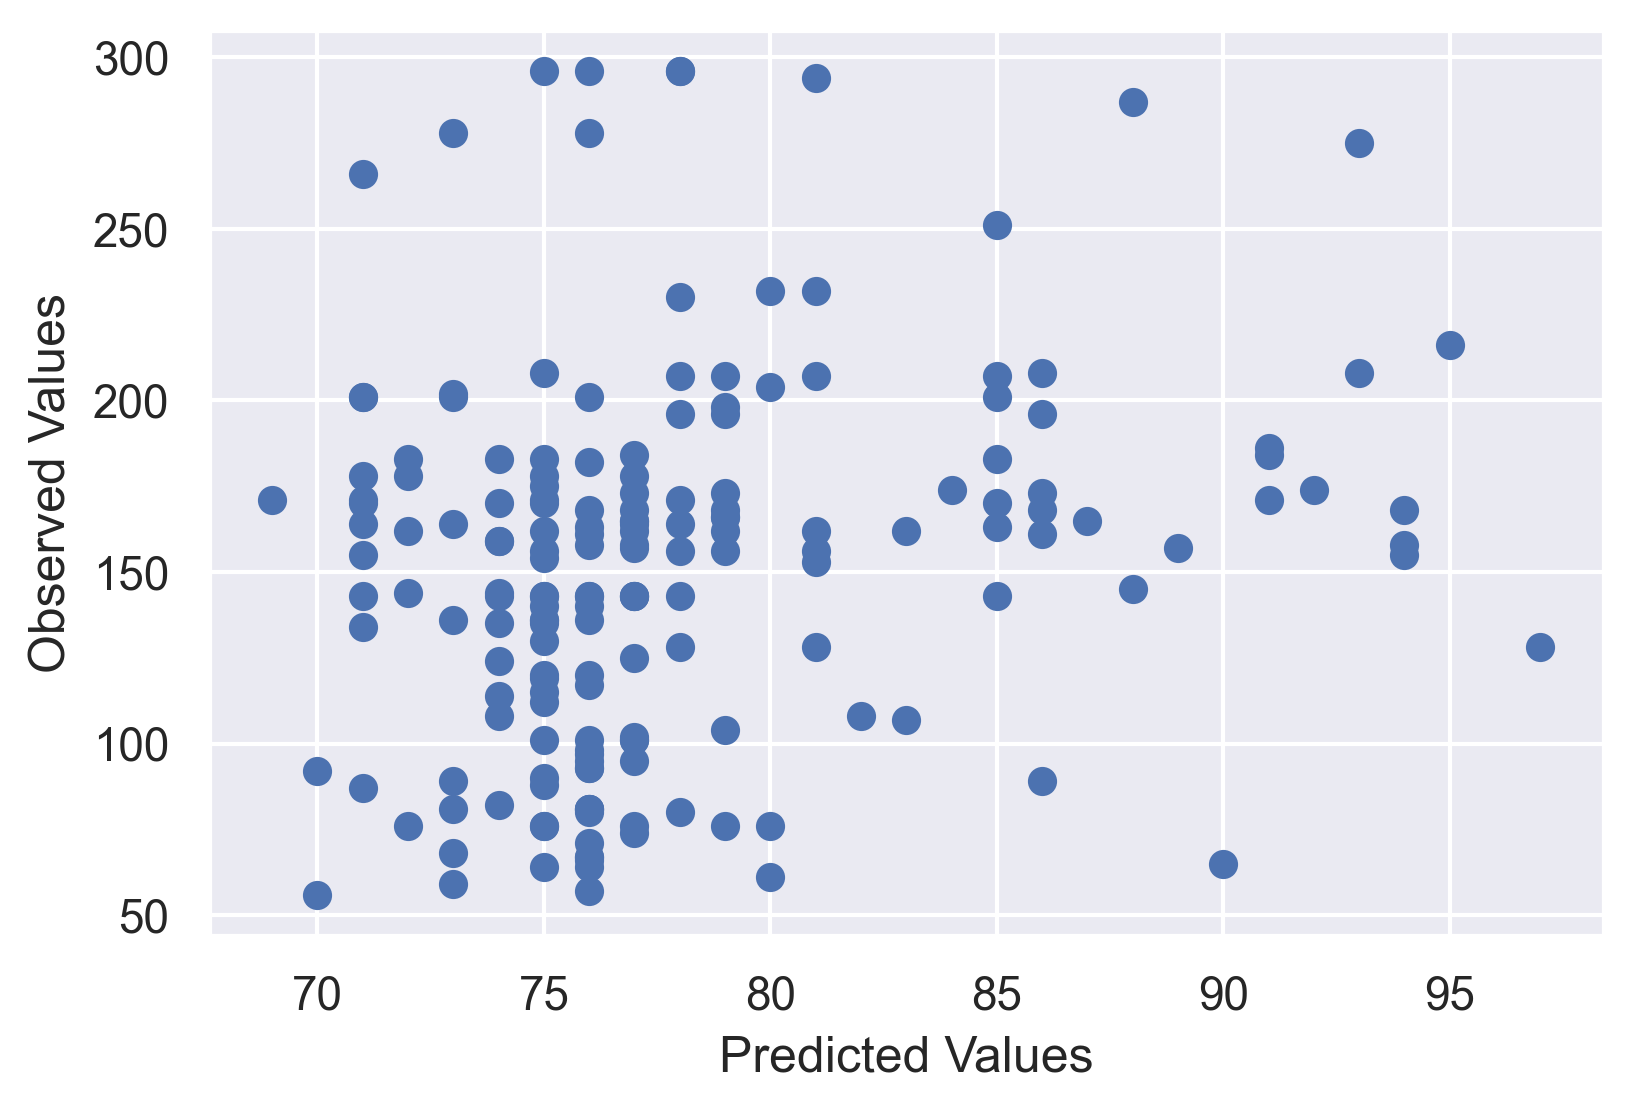

In [73]:
xpoints = np.array(predic)
ypoints = np.array(obser)

plt.scatter(xpoints, ypoints)
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.gcf().set_dpi(300)
plt.show()


In [74]:
my_rho = np.corrcoef(predic, obser)

print(my_rho)

[[1.         0.22452313]
 [0.22452313 1.        ]]


In [75]:

from sklearn.metrics import r2_score

r2 = r2_score(obser, predic)
r2

-1.779262518127974

## EfficientNetB2

In [76]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input

efficientnetb7 = EfficientNetB7(input_shape=[120,200]+ [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in efficientnetb7.layers:
    layer.trainable = False
    
x = Flatten()(efficientnetb7.output)
prediction = Dense(1, activation='linear')(x)

# create a model object
model = Model(inputs=efficientnetb7.input, outputs=prediction)
model.summary()

258088960/258076736 [==============================] - 382s 1us/step
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 120, 200, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 120, 200, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 120, 200, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 121, 201, 3)  0           normalization[0][0]              
_______________________

In [77]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
optimum=Adam(lr=0.000001)
# model.compile(optimizer=RMSprop(lr=0.00001), loss='mean_squared_error',metrics=['mean_squared_error'])
model.compile(optimizer=optimum, loss='mean_absolute_error',metrics=['mean_squared_error',tf.keras.metrics.RootMeanSquaredError()])

C:\Users\joyan\AppData\Roaming\Python\Python36\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [78]:
import time
start = time.process_time()
hist = model.fit(x_train, y_train, 
           batch_size=8, epochs=350, validation_split=0.1 )
print(time.process_time() - start)

Epoch 1/350
184/184 [==============================] - 93s 358ms/step - loss: 138.2249 - mean_squared_error: 22386.0332 - root_mean_squared_error: 149.6196 - val_loss: 142.9054 - val_mean_squared_error: 24074.8926 - val_root_mean_squared_error: 155.1609
Epoch 2/350
184/184 [==============================] - 23s 126ms/step - loss: 129.7096 - mean_squared_error: 20104.9941 - root_mean_squared_error: 141.7921 - val_loss: 134.1742 - val_mean_squared_error: 21655.7520 - val_root_mean_squared_error: 147.1589
Epoch 3/350
184/184 [==============================] - 25s 133ms/step - loss: 121.1011 - mean_squared_error: 17958.4258 - root_mean_squared_error: 134.0090 - val_loss: 125.4093 - val_mean_squared_error: 19380.6152 - val_root_mean_squared_error: 139.2143
Epoch 4/350
184/184 [==============================] - 23s 127ms/step - loss: 112.5288 - mean_squared_error: 15972.0449 - root_mean_squared_error: 126.3806 - val_loss: 116.7516 - val_mean_squared_error: 17269.9570 - val_root_mean_squared_

In [79]:
predictions = model.predict([x_test])
pred=[]
for i in predictions:
    print(int(i[0]))
    pred.append(int(i[0]))
    
for i in y_test:
    print(i)
    
diff=[]
for i in range(len(pred)):
    diff.append(abs(y_test[i]-pred[i]))
print(sum(diff) / len(diff))


for i in diff:
    print(i)

156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
155
155
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
155
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
155
156
156
156
156
155
155
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
155
155
156
156
156
156
156
156
156
156
156
156
156
156
156
156
155
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
155
156
156
156
155
156
156
156
155
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
155
156
156
155
156
156
156
156
156
156
156
156
156
156
156
156
156
156
155
155
156
101.0
182.0
89.0
294.0
162.0
90.0
145.0
168.0
136.0
143.0
171.0
107.0
186.0
143.0
165.0
89.0
287.0
81.0
266.0
296.0
165.0
108.0
101.0
134.0
119.0
98.0
155.0
230.0
143.0
168.0
56.0
81.0
196.0
162.0
81.0
196.0
208.0
102.0
135.0
204.0
207.0
140.0
171.0
93.0
207.0
101.0
82.0


In [80]:
eva = model.evaluate(x_test, y_test)
print(eva)

6/6 [==============================] - 1s 186ms/step - loss: 41.3447 - mean_squared_error: 2945.9453 - root_mean_squared_error: 54.2766
[41.344749450683594, 2945.9453125, 54.27656173706055]


In [81]:
predic=[]
obser=[]
for i in range(len(pred)):
    predic.append(pred[i])
    obser.append(y_test[i])

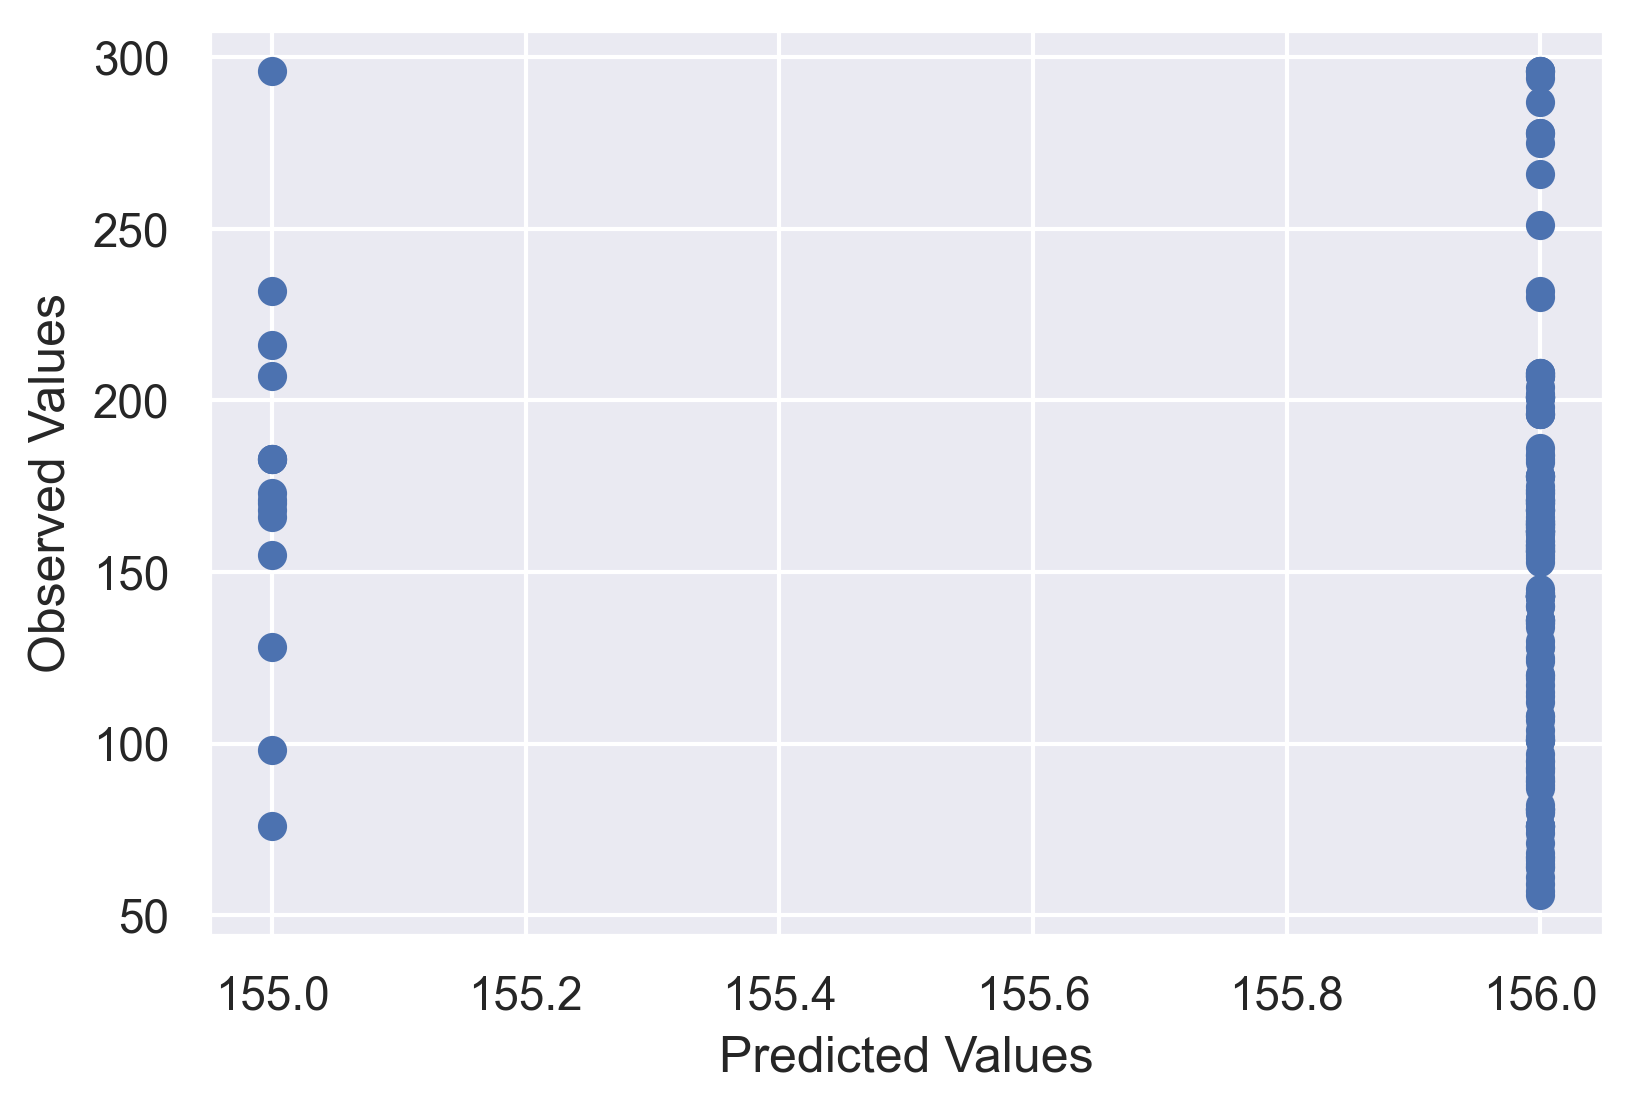

In [82]:
xpoints = np.array(predic)
ypoints = np.array(obser)

plt.scatter(xpoints, ypoints)
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.gcf().set_dpi(300)
plt.show()


In [83]:
my_rho = np.corrcoef(predic, obser)

print(my_rho)

[[ 1.        -0.1413061]
 [-0.1413061  1.       ]]


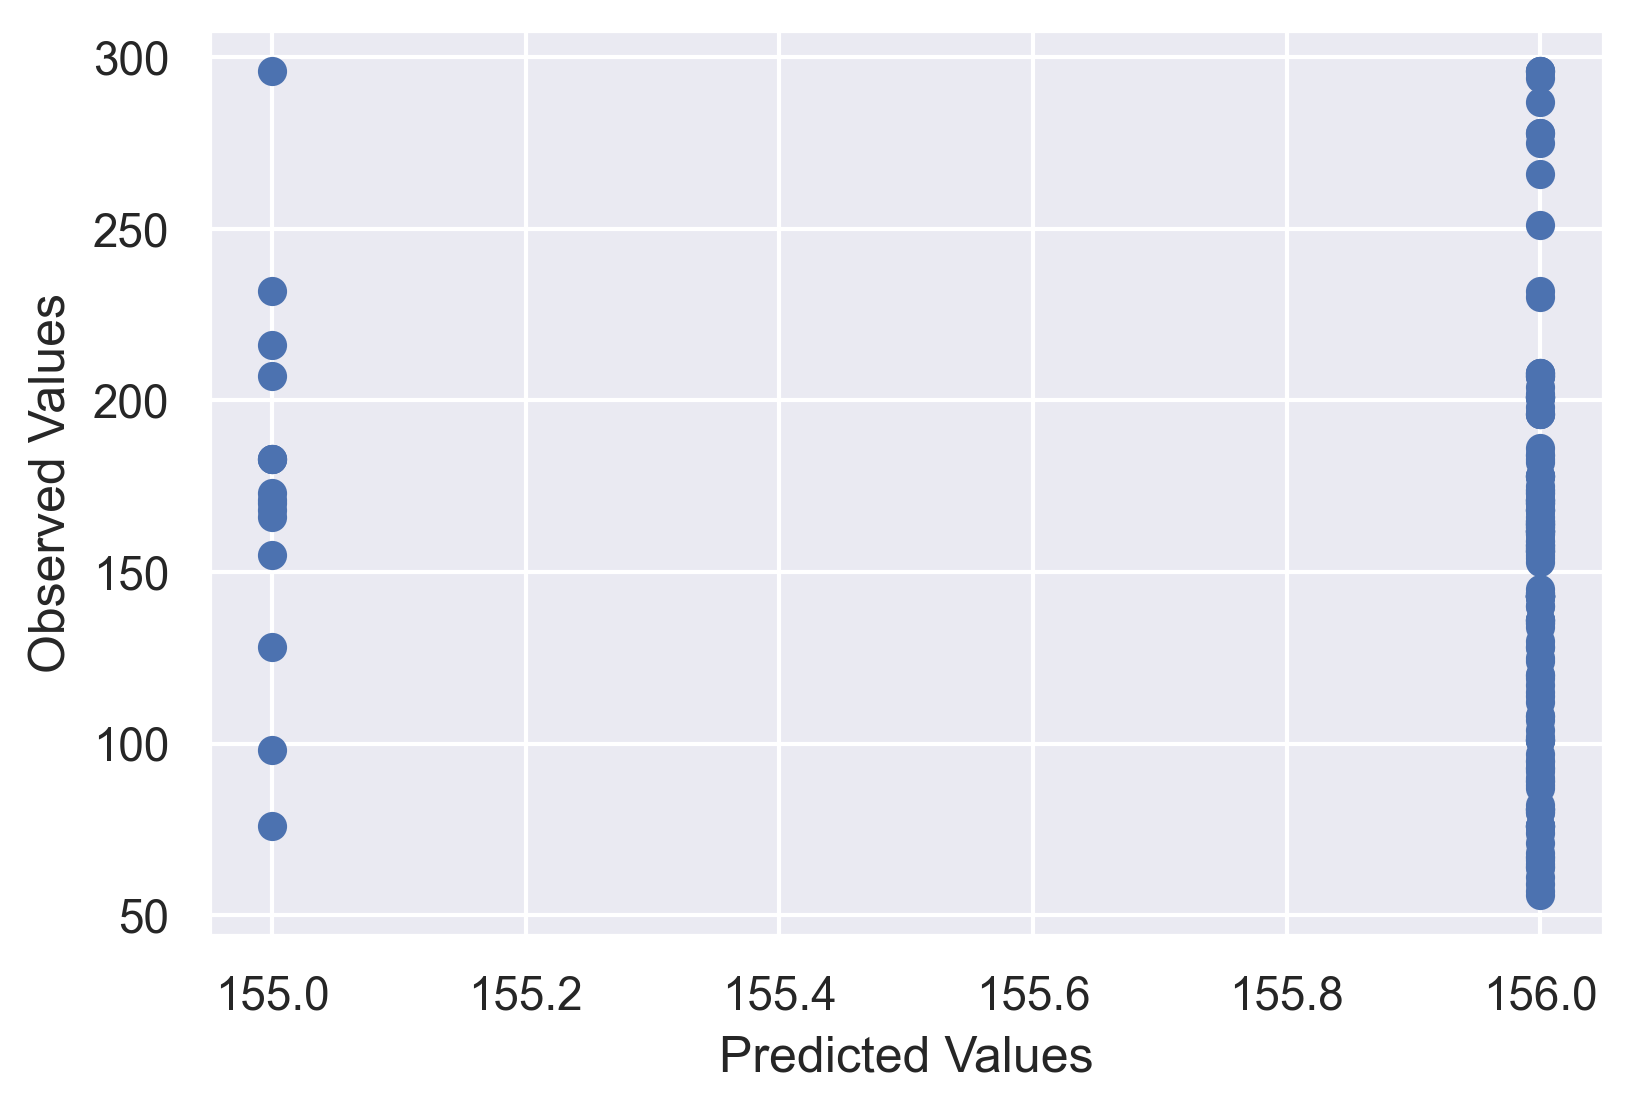

In [84]:
predic=[]
obser=[]
for i in range(len(pred)):
    predic.append(pred[i])
    obser.append(y_test[i])
    
xpoints = np.array(predic)
ypoints = np.array(obser)

plt.scatter(xpoints, ypoints)
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.gcf().set_dpi(300)
plt.show()


In [85]:

from sklearn.metrics import r2_score

r2 = r2_score(obser, predic)
r2

-0.01071301033003813

## MobileNetV2

In [86]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

mobilenetv2 = MobileNetV2(input_shape=[120,200]+ [3], weights='imagenet', include_top=False)
# don't train existing weights
for layer in mobilenetv2.layers:
    layer.trainable = False
    
x = Flatten()(mobilenetv2.output)

prediction = Dense(1, activation='linear')(x)

# create a model object
model = Model(inputs=mobilenetv2.input, outputs=prediction)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 120, 200, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 60, 100, 32)  864         input_5[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 60, 100, 32)  128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 60, 100, 32)  0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [87]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
optimum=Adam(lr=0.000001)
# model.compile(optimizer=RMSprop(lr=0.00001), loss='mean_squared_error',metrics=['mean_squared_error'])
model.compile(optimizer=optimum, loss='mean_absolute_error',metrics=['mean_squared_error',tf.keras.metrics.RootMeanSquaredError()])

C:\Users\joyan\AppData\Roaming\Python\Python36\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [88]:
import time
start = time.process_time()
hist = model.fit(x_train, y_train, 
           batch_size=8, epochs=350, validation_split=0.1 )
print(time.process_time() - start)

Epoch 1/350
184/184 [==============================] - 12s 47ms/step - loss: 143.5623 - mean_squared_error: 23891.8594 - root_mean_squared_error: 154.5699 - val_loss: 151.8640 - val_mean_squared_error: 26711.8301 - val_root_mean_squared_error: 163.4375
Epoch 2/350
184/184 [==============================] - 4s 20ms/step - loss: 141.3460 - mean_squared_error: 23273.9238 - root_mean_squared_error: 152.5579 - val_loss: 149.6674 - val_mean_squared_error: 26057.8809 - val_root_mean_squared_error: 161.4245
Epoch 3/350
184/184 [==============================] - 4s 19ms/step - loss: 139.1268 - mean_squared_error: 22663.1309 - root_mean_squared_error: 150.5428 - val_loss: 147.4675 - val_mean_squared_error: 25413.4219 - val_root_mean_squared_error: 159.4159
Epoch 4/350
184/184 [==============================] - 4s 19ms/step - loss: 136.9071 - mean_squared_error: 22057.5391 - root_mean_squared_error: 148.5178 - val_loss: 145.2668 - val_mean_squared_error: 24779.3770 - val_root_mean_squared_error: 

In [89]:
predictions = model.predict([x_test])
pred=[]
for i in predictions:
    print(int(i[0]))
    pred.append(int(i[0]))
    
for i in y_test:
    print(i)
    
diff=[]
for i in range(len(pred)):
    diff.append(abs(y_test[i]-pred[i]))
print(sum(diff) / len(diff))


for i in diff:
    print(i)

101
170
158
164
178
98
153
148
112
106
165
161
172
113
197
162
160
118
99
149
152
211
108
126
119
140
188
157
165
199
152
110
137
180
94
181
153
99
130
141
163
100
144
131
151
106
89
185
180
107
148
172
142
117
95
86
107
95
89
150
173
102
106
106
125
150
98
135
144
113
91
143
157
145
127
86
106
83
116
103
134
185
105
176
175
204
120
166
113
116
105
124
112
168
175
180
93
204
171
89
99
118
184
105
106
147
109
141
118
195
103
152
98
164
123
169
100
137
120
174
104
120
177
140
167
115
153
200
96
146
167
122
194
149
88
160
111
102
106
173
215
128
82
183
149
112
127
149
193
174
141
191
94
144
148
118
127
134
171
94
96
213
159
134
154
153
102
134
127
179
170
146
162
170
165
123
149
123
128
147
139
101
101.0
182.0
89.0
294.0
162.0
90.0
145.0
168.0
136.0
143.0
171.0
107.0
186.0
143.0
165.0
89.0
287.0
81.0
266.0
296.0
165.0
108.0
101.0
134.0
119.0
98.0
155.0
230.0
143.0
168.0
56.0
81.0
196.0
162.0
81.0
196.0
208.0
102.0
135.0
204.0
207.0
140.0
171.0
93.0
207.0
101.0
82.0
136.0
183.0
143.0
76.0


In [90]:
eva = model.evaluate(x_test, y_test)
print(eva)

6/6 [==============================] - 0s 27ms/step - loss: 40.0906 - mean_squared_error: 2746.3887 - root_mean_squared_error: 52.4060
[40.09062957763672, 2746.388671875, 52.40599822998047]


In [91]:
predic=[]
obser=[]
for i in range(len(pred)):
    predic.append(pred[i])
    obser.append(y_test[i])

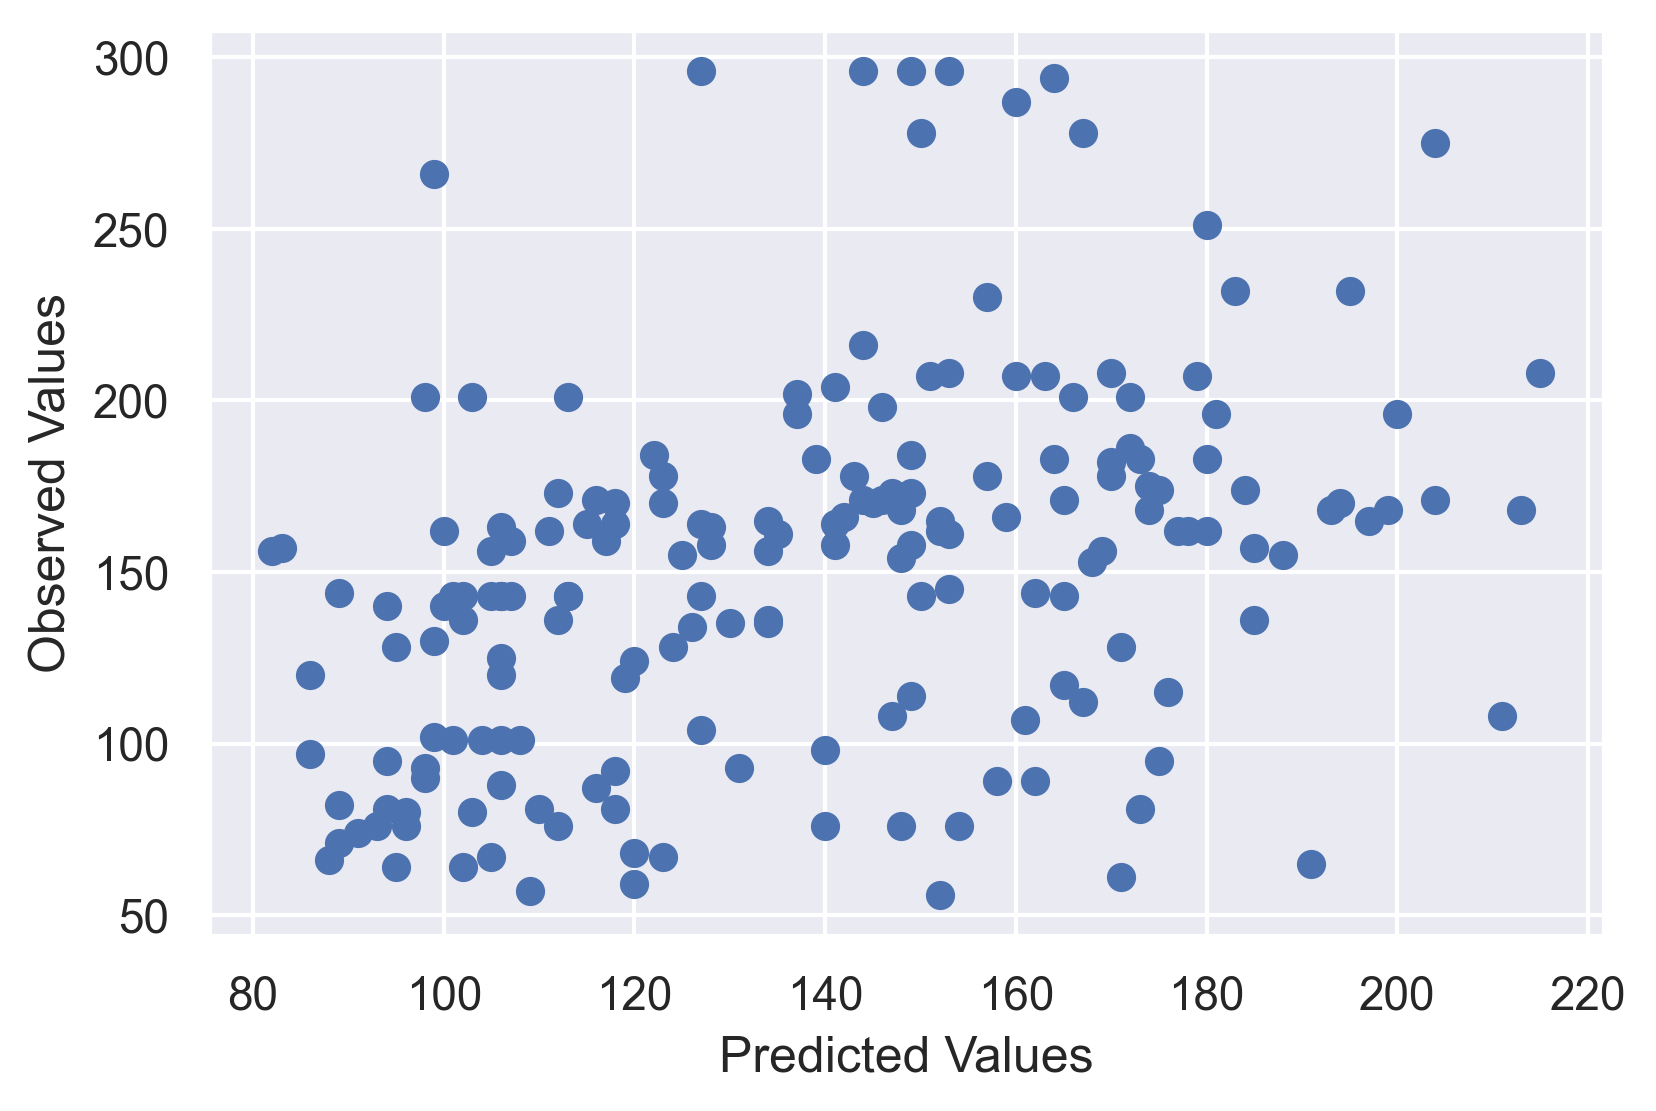

In [92]:
xpoints = np.array(predic)
ypoints = np.array(obser)

plt.scatter(xpoints, ypoints)
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.gcf().set_dpi(300)
plt.show()


In [93]:
my_rho = np.corrcoef(predic, obser)

print(my_rho)

[[1.         0.38794542]
 [0.38794542 1.        ]]


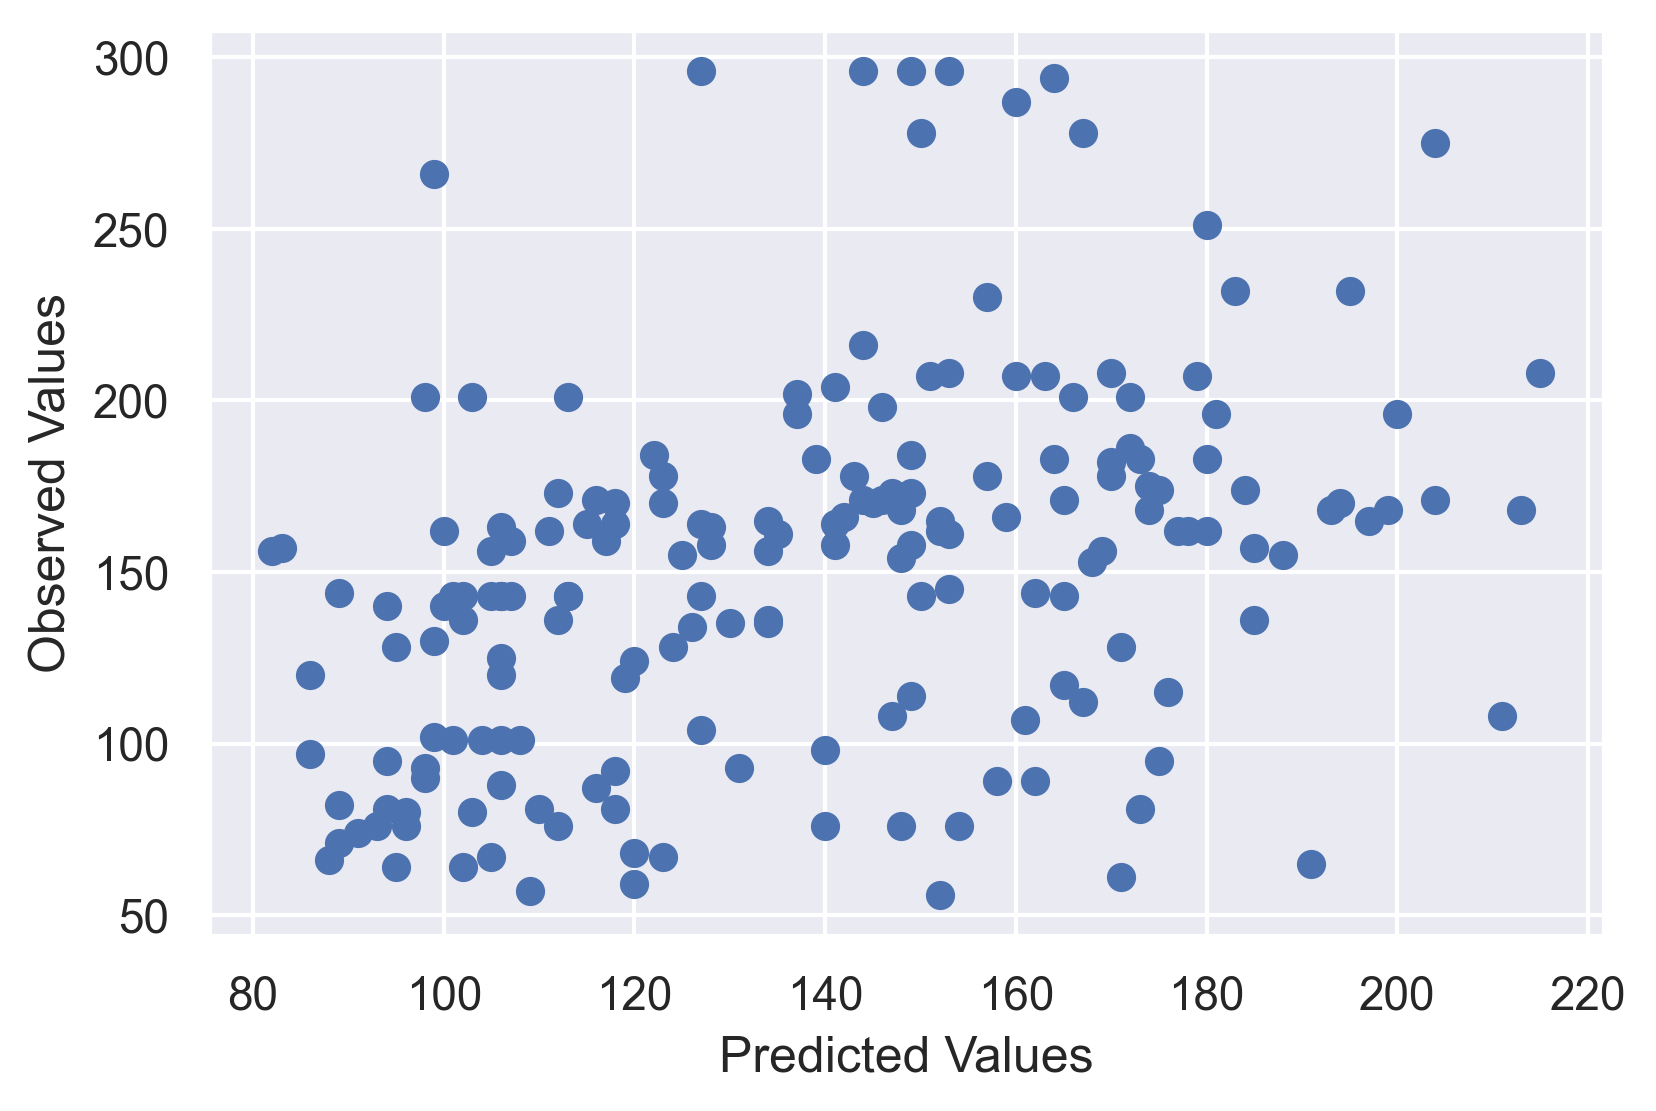

In [94]:
predic=[]
obser=[]
for i in range(len(pred)):
    predic.append(pred[i])
    obser.append(y_test[i])
    
xpoints = np.array(predic)
ypoints = np.array(obser)

plt.scatter(xpoints, ypoints)
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.gcf().set_dpi(300)
plt.show()


In [95]:

from sklearn.metrics import r2_score

r2 = r2_score(obser, predic)
r2

0.05321815955485942